In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer


# 1. Dataset Preparation

## 1.1 Loading Dataset

In [2]:
dataset = pd.read_csv("data/final_dataset.csv")
print("Shape of dataset:", dataset.shape)
dataset.head()

Shape of dataset: (239381, 74)


,date,year,populous_city,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,...,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,month_x,month_y
0,771.0,2015.0,1,39.8322,-86.2492,19.0,19.0,19.0,0.0,1.0,...,False,False,False,False,False,False,False,False,5.000000e-01,-0.866025
1,1491.0,2017.0,0,41.6645,-78.7856,62.0,62.0,62.0,0.0,1.0,...,False,False,False,False,False,False,False,False,8.660254e-01,-0.500000
2,1131.0,2016.0,1,42.4190,-83.0393,28.0,31.0,37.0,0.0,0.0,...,False,False,False,False,False,False,False,False,-5.000000e-01,0.866025
3,1132.0,2016.0,1,38.9030,-76.9820,21.0,21.0,21.0,0.0,1.0,...,False,False,False,False,False,False,False,False,-8.660254e-01,0.500000
4,770.0,2015.0,0,40.4621,-80.0308,2.0,20.0,26.0,0.0,1.0,...,False,False,False,False,False,False,False,False,1.224647e-16,-1.000000


In [3]:
print("There are NaN values:", dataset.isnull().values.any())

There are NaN values: False


In [4]:
print(dataset.columns)

Index(['date', 'year', 'populous_city', 'latitude', 'longitude',
       'min_age_participants', 'avg_age_participants', 'max_age_participants',
       'teen_ratio', 'adults_ratio', 'males_ratio', 'killed_ratio',
       'injured_ratio', 'arrested_ratio', 'n_participants',
       'povertyPercentage', 'party', 'totalvotes', 'republicans_ratio',
       'democrats_ratio', 'state_population', 'state_Alabama', 'state_Alaska',
       'state_Arizona', 'state_Arkansas', 'state_California', 'state_Colorado',
       'state_Connecticut', 'state_Delaware', 'state_District of Columbia',
       'state_Florida', 'state_Georgia', 'state_Hawaii', 'state_Idaho',
       'state_Illinois', 'state_Indiana', 'state_Iowa', 'state_Kansas',
       'state_Kentucky', 'state_Louisiana', 'state_Maine', 'state_Maryland',
       'state_Massachusetts', 'state_Michigan', 'state_Minnesota',
       'state_Mississippi', 'state_Missouri', 'state_Montana',
       'state_Nebraska', 'state_Nevada', 'state_New Hampshire',
      

## 1.2 Outlier detection

In [5]:
def return_whiskers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_whisker = q1 - 1.5 * iqr
    upper_whisker = q3 + 1.5 * iqr
    return lower_whisker, upper_whisker

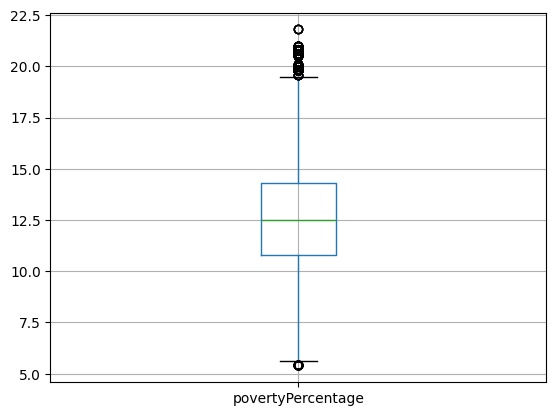

In [6]:
boxplot = dataset.boxplot(column=['povertyPercentage'])
plt.show()

In [7]:
lower_whisker_poverty, upper_whisker_poverty = return_whiskers(dataset, 'povertyPercentage')
print("Amount of outliers in povertyPercentage:", dataset[(dataset['povertyPercentage'] < lower_whisker_poverty) | (dataset['povertyPercentage'] > upper_whisker_poverty)].shape[0])

Amount of outliers in povertyPercentage: 7379


Values for poverty percentages that are outliers are still realistic and close to whiskers. Furthermore, poverty percentage is a key attribute of our analysis, so we decide to keep all the data points.

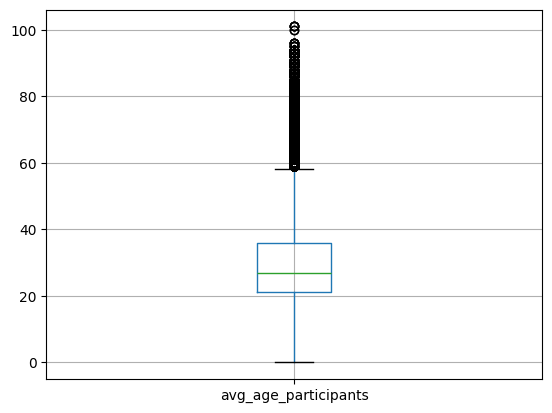

In [8]:
boxplot = dataset.boxplot(column = ['avg_age_participants'])
plt.show()

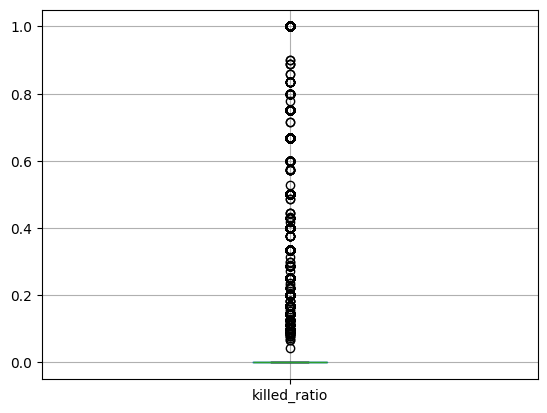

In [9]:
boxplot = dataset.boxplot(column = ['killed_ratio'])
plt.show()

Drop outliers for unrealistic values of avg age participants which may negatively influence clustering.

In [10]:
# Get whisker value of boxplot for avg_age_participants
lower_whisker_avg_age, upper_whisker_avg_age = return_whiskers(dataset, 'avg_age_participants')

# Drop rows with avg_age_participants > upper_whisker
dataset = dataset[dataset['avg_age_participants'] <= upper_whisker_avg_age]
print("Shape of dataset after removing outliers:", dataset.shape)

Shape of dataset after removing outliers: (230776, 74)


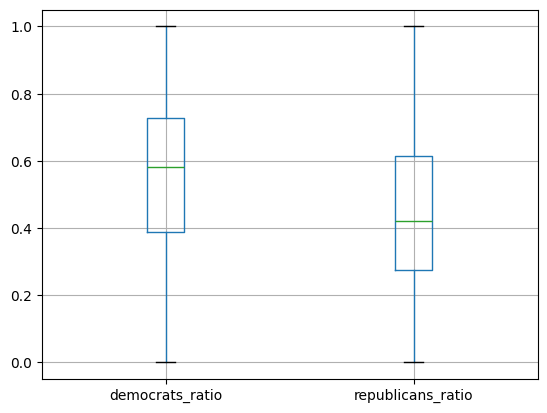

In [11]:
boxplot = dataset.boxplot(column = ['democrats_ratio', 'republicans_ratio'])
plt.show()

Values of 100% or 0% are pretty unrealistic, so we decide to drop all over 95% (or below 5%), considering them as outliers / wrongly observed data. Moreover, we will keep only one of the two ratios, and also drop the winning party attribute. For this reason, we decide to drop strange observations where the party that won had less than 50% of the votes.

In [12]:
print("Amount of reublicans_ratio outliers:", dataset[dataset['republicans_ratio'] == 1].shape[0] + dataset[dataset['republicans_ratio'] == 0].shape[0])
print("Amount of democrats_ratio outliers:", dataset[dataset['democrats_ratio'] == 1].shape[0] + dataset[dataset['democrats_ratio'] == 0].shape[0])

# Drop rows with republicans_ratio <= 0.05 or >= 0.95
dataset = dataset[(dataset['republicans_ratio'] > 0.05) & (dataset['republicans_ratio'] < 0.95)]
print("Shape of dataset after removing outliers:", dataset.shape)

Amount of reublicans_ratio outliers: 7372
Amount of democrats_ratio outliers: 7372
Shape of dataset after removing outliers: (218335, 74)


In [13]:
# Check how many times a party won and the percentage of votes for that part was <0.5
democrats_strange = len(dataset[(dataset['republicans_ratio'] > 0.5 ) & (dataset['party'] == 0)])
republicans_strange = len(dataset[(dataset['republicans_ratio'] < 0.5 ) & (dataset['party'] == 1)])

print("Amount of times democrats won and the percentage of votes for that part was <0.5:", democrats_strange)
print("Amount of times republicans won and the percentage of votes for that part was <0.5:", republicans_strange)
print("Amount of strange wins:", democrats_strange + republicans_strange)

# Drop rows with republican strange wins
dataset = dataset[((dataset['republicans_ratio'] > 0.5) & (dataset['party'] == 1)) | ((dataset['republicans_ratio'] < 0.5) & (dataset['party'] == 0))]
print("Shape of dataset after removing outliers:", dataset.shape)


Amount of times democrats won and the percentage of votes for that part was <0.5: 2959
Amount of times republicans won and the percentage of votes for that part was <0.5: 5712
Amount of strange wins: 8671
Shape of dataset after removing outliers: (209664, 74)


## 1.3 Dropping columns for different algorithms

In [14]:
dropped_columns = ['min_age_participants', 'max_age_participants', 'teen_ratio', 'totalvotes', 'year', 'party', 'democrats_ratio']
print("Attributes to drop:", dropped_columns)
dataset_reduced = dataset.drop(columns=dropped_columns, axis = 1)
print("Shape of dataset:", dataset_reduced.shape)

Attributes to drop: ['min_age_participants', 'max_age_participants', 'teen_ratio', 'totalvotes', 'year', 'party', 'democrats_ratio']
Shape of dataset: (209664, 67)


In [15]:
selected_state = "Florida"
dataset_reduced_florida = dataset_reduced[dataset_reduced["state_" + selected_state] == True]

In [16]:
dropped_columns = [c for c in dataset_reduced.columns if c.startswith('state_')]
print("Attributes to drop:", dropped_columns)

dataset_reduced = dataset_reduced.drop(columns=dropped_columns, axis = 1)
dataset_reduced_florida = dataset_reduced_florida.drop(columns=dropped_columns, axis = 1)

print("Shape of dataset:", dataset_reduced.shape)
print("Shape of dataset for florida:", dataset_reduced_florida.shape)

Attributes to drop: ['state_population', 'state_Alabama', 'state_Alaska', 'state_Arizona', 'state_Arkansas', 'state_California', 'state_Colorado', 'state_Connecticut', 'state_Delaware', 'state_District of Columbia', 'state_Florida', 'state_Georgia', 'state_Hawaii', 'state_Idaho', 'state_Illinois', 'state_Indiana', 'state_Iowa', 'state_Kansas', 'state_Kentucky', 'state_Louisiana', 'state_Maine', 'state_Maryland', 'state_Massachusetts', 'state_Michigan', 'state_Minnesota', 'state_Mississippi', 'state_Missouri', 'state_Montana', 'state_Nebraska', 'state_Nevada', 'state_New Hampshire', 'state_New Jersey', 'state_New Mexico', 'state_New York', 'state_North Carolina', 'state_North Dakota', 'state_Ohio', 'state_Oklahoma', 'state_Oregon', 'state_Pennsylvania', 'state_Rhode Island', 'state_South Carolina', 'state_South Dakota', 'state_Tennessee', 'state_Texas', 'state_Utah', 'state_Vermont', 'state_Virginia', 'state_Washington', 'state_West Virginia', 'state_Wisconsin', 'state_Wyoming']
Shape o

## 1.4 Scaling

In [17]:
scaler = MinMaxScaler()
scaled_dataset = scaler.fit_transform(dataset_reduced.values)

scaler_florida= MinMaxScaler()
scaled_dataset_florida = scaler_florida.fit_transform(dataset_reduced_florida.values)

print("Shape of scaled dataset:", scaled_dataset.shape)
print("Shape of scaled dataset for florida:", scaled_dataset_florida.shape)

Shape of scaled dataset: (209664, 15)
Shape of scaled dataset for florida: (13262, 15)


# 2. K Means

## 2.1 Identification of the best value of k

In [21]:
sse_list = []
silhouette_list = []
davies_bouldin_list = []

max_k = 20
for k in tqdm(range(2, max_k + 1), ):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(scaled_dataset)

    sse_list.append(kmeans.inertia_)
    silhouette_list.append(silhouette_score(scaled_dataset, kmeans.labels_, sample_size=10000))
    davies_bouldin_list.append(davies_bouldin_score(scaled_dataset, kmeans.labels_))

100%|██████████| 19/19 [00:54<00:00,  2.87s/it]


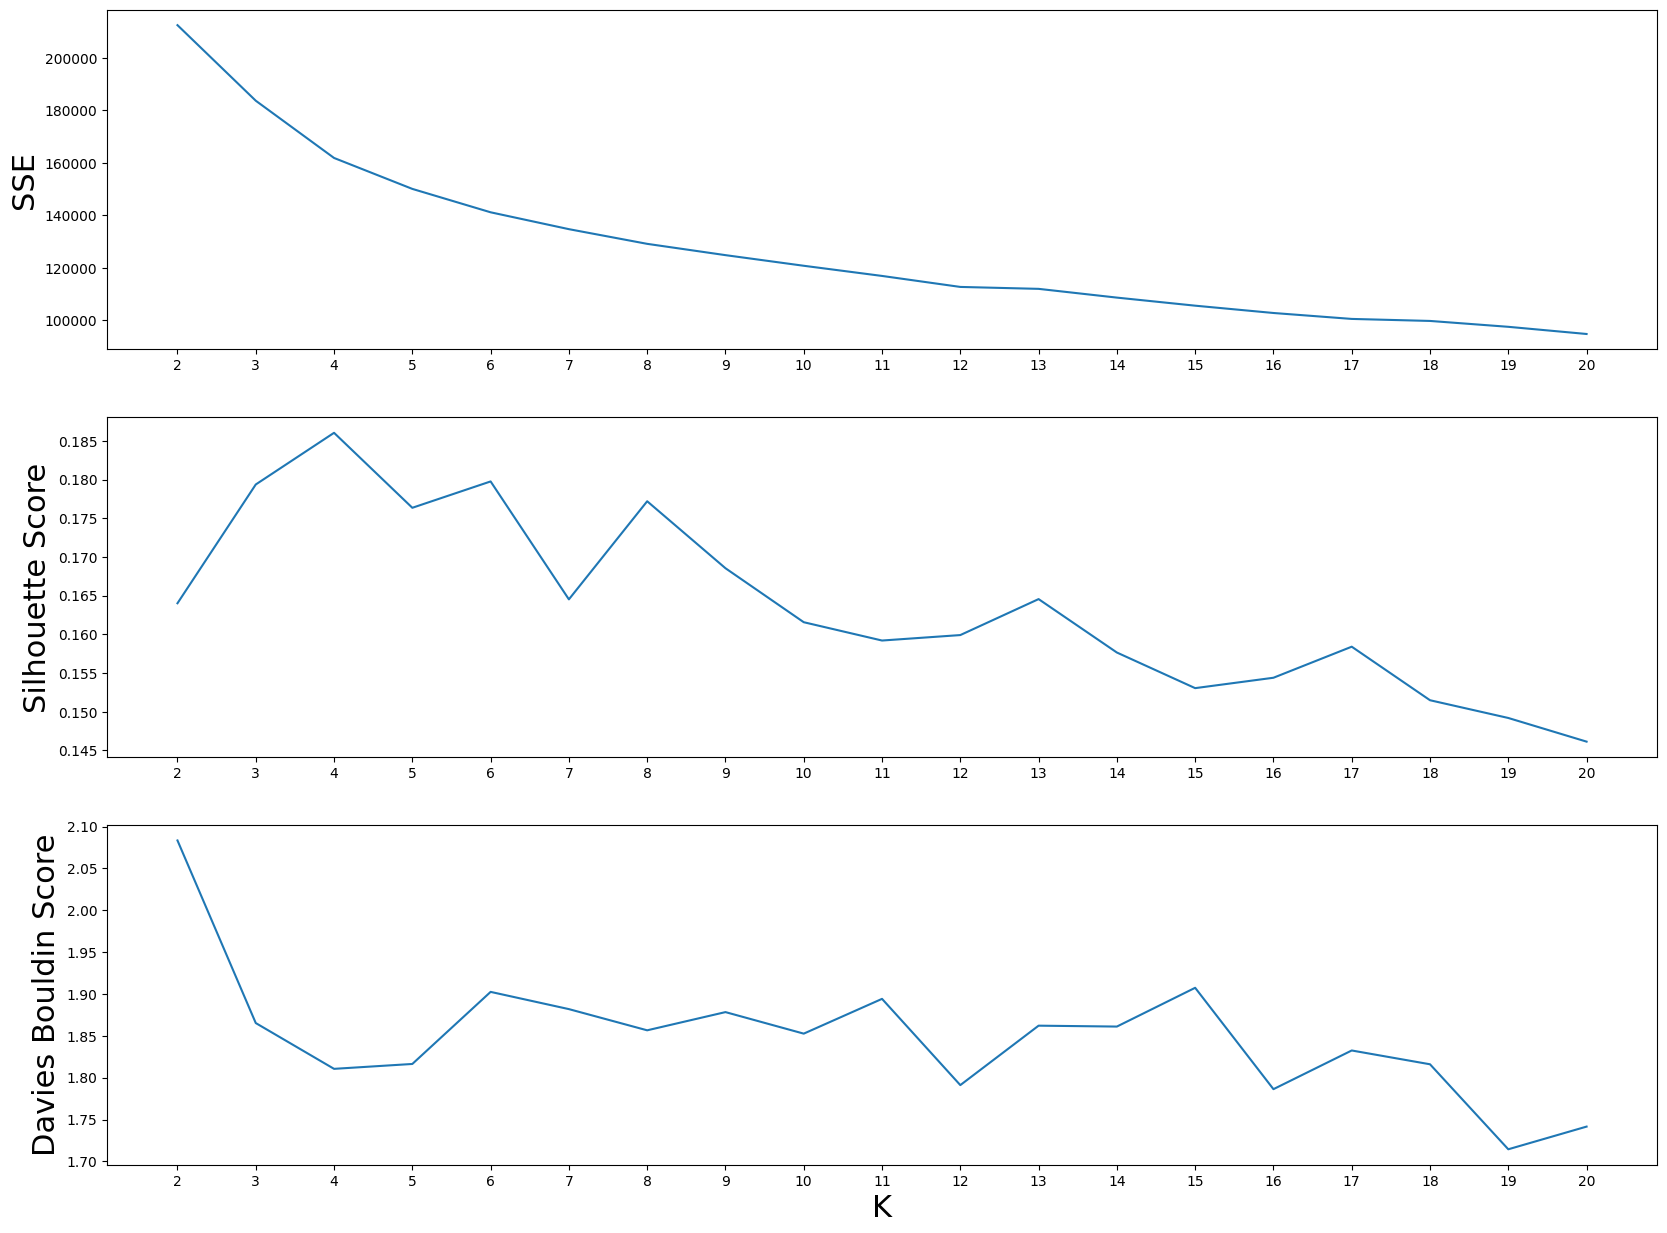

In [22]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list) + 2), sse_list)
ax[0].set_ylabel('SSE', fontsize=22)
ax[0].set_xticks(range(2, len(sse_list) + 2))

ax[1].plot(range(2, len(silhouette_list) + 2), silhouette_list)
ax[1].set_ylabel('Silhouette Score', fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list) + 2))

ax[2].plot(range(2, len(davies_bouldin_list) + 2), davies_bouldin_list)
ax[2].set_ylabel('Davies Bouldin Score', fontsize=22)
ax[2].set_xticks(range(2, len(davies_bouldin_list) + 2))

plt.xlabel('K', fontsize=22)
plt.show()

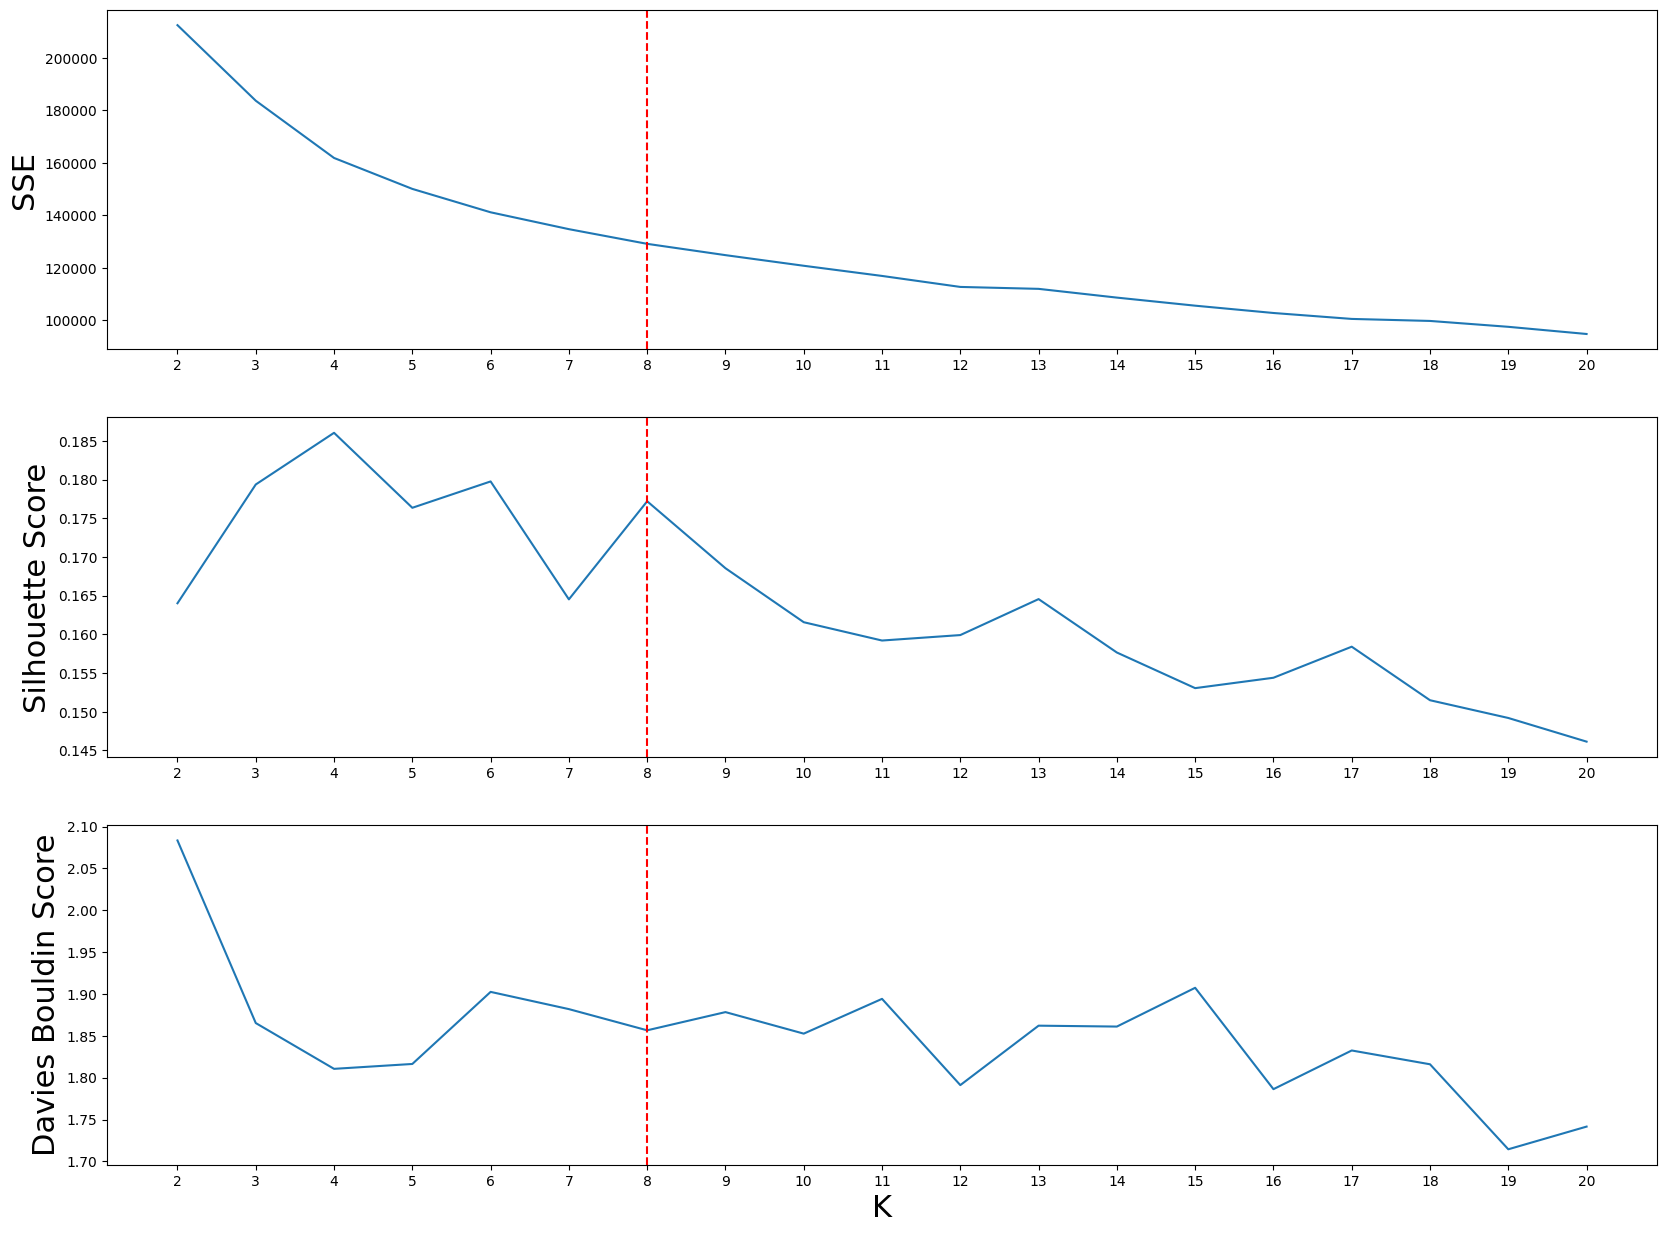

In [23]:
CHOSEN_K = 8

fig, ax = plt.subplots(3, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list) + 2), sse_list)
ax[0].set_ylabel('SSE', fontsize=22)
ax[0].set_xticks(range(2, len(sse_list) + 2))

ax[1].plot(range(2, len(silhouette_list) + 2), silhouette_list)
ax[1].set_ylabel('Silhouette Score', fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list) + 2))

ax[2].plot(range(2, len(davies_bouldin_list) + 2), davies_bouldin_list)
ax[2].set_ylabel('Davies Bouldin Score', fontsize=22)
ax[2].set_xticks(range(2, len(davies_bouldin_list) + 2))

# set a vertical line on all three subplots at x = CHOSEN_K
for i in range(3):
    ax[i].axvline(x=CHOSEN_K, color='r', linestyle='--')

plt.xlabel('K', fontsize=22)
plt.show()


## 2.2 Analysis of the centroids and clusters

In [28]:
n_clusters = CHOSEN_K
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
kmeans.fit(scaled_dataset)

KMeans(n_init=20)

In [29]:
print("Shape of scaled_dataset: ", scaled_dataset.shape)
print("Shape of kmeans.labels_: ", kmeans.labels_.shape)
print("Shape of kmeans.cluster_centers_: ", kmeans.cluster_centers_.shape)

Shape of scaled_dataset:  (209664, 15)
Shape of kmeans.labels_:  (209664,)
Shape of kmeans.cluster_centers_:  (8, 15)


In [30]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=dataset_reduced.columns)
centers_df.head(7)

,date,populous_city,latitude,longitude,avg_age_participants,adults_ratio,males_ratio,killed_ratio,injured_ratio,arrested_ratio,n_participants,povertyPercentage,republicans_ratio,month_x,month_y
0,862.062157,-1.193490e-15,37.291774,-89.261679,29.161440,0.926435,0.880013,0.101210,0.164012,0.139543,2.293185,13.112502,0.498807,-0.482044,-0.458071
1,1032.364558,1.000000e+00,37.407630,-90.550234,28.207790,0.906804,0.891161,0.072685,0.077951,0.410218,2.167606,12.647401,0.337643,0.039661,-0.006508
2,1202.224181,-2.386980e-15,38.463616,-90.549398,28.951233,0.911242,0.915109,0.012560,0.008016,0.970248,1.651087,11.942505,0.503379,0.060234,0.038213
3,1007.421029,-5.773160e-15,37.038219,-89.461844,29.058933,0.919344,0.872562,0.108335,0.181466,0.158846,2.233223,13.017382,0.497562,0.497568,0.458767
4,1052.892409,-1.637579e-15,37.462830,-88.154866,27.496142,0.886503,0.876492,0.003407,0.981684,0.004213,1.448942,12.692733,0.447562,-0.015595,-0.022028
5,1007.279720,1.000000e+00,37.293742,-90.967299,30.010255,0.945796,0.907257,0.859750,0.045292,0.003692,1.497384,12.322007,0.307616,0.005014,-0.021946
6,1016.130629,1.000000e+00,38.835306,-87.745301,27.101109,0.888455,0.884590,0.007145,0.882691,0.003436,1.602913,11.901525,0.285074,-0.023825,-0.060234


In [31]:
cluster_num_points = []
cluster_points = []
for i in range(n_clusters):
    cluster_points.append(scaled_dataset[kmeans.labels_ == i])
    cluster_num_points.append(len(cluster_points[-1]))
    
cluster_num_points, cluster_points[0].shape

([35394, 18659, 35003, 33886, 35254, 9542, 23266, 18660], (35394, 15))

In [32]:
kmeans_tot = KMeans(n_clusters=1, n_init=10)
kmeans_tot.fit(scaled_dataset)
total_SSE = kmeans_tot.inertia_ / len(scaled_dataset)

cluster_SSE = []
for i in range(n_clusters):
    cluster_sse = 0
    for point in cluster_points[i]:
        cluster_sse += np.linalg.norm(point - kmeans.cluster_centers_[i])**2
    cluster_SSE.append(cluster_sse / cluster_num_points[i])

print("Cluster SSE: ", cluster_SSE)
print("Total SSE: ", total_SSE)
print("SSE of cluster with min SSE: ", min(cluster_SSE))
print("SSE of cluster with max SSE: ", max(cluster_SSE))
print("Mean of SSE: ", np.mean(cluster_SSE))

Cluster SSE:  [0.5774135446546492, 0.7828211604494224, 0.5639471821618797, 0.6083918357721527, 0.6348909279919429, 0.597374818234633, 0.6162658382738849, 0.6050371536352805]
Total SSE:  1.212051915638985
SSE of cluster with min SSE:  0.5639471821618797
SSE of cluster with max SSE:  0.7828211604494224
Mean of SSE:  0.6232678076467307


In [33]:
cluster_distance_variance = []
total_distance_variance = 0
dataset_centroid = np.mean(scaled_dataset, axis=0)

for point in scaled_dataset:
    total_distance_variance += (np.linalg.norm(point - dataset_centroid)**2 - total_SSE) ** 2
total_distance_variance /= len(scaled_dataset)

for i in range(n_clusters):
    variance = 0
    for p in cluster_points[i]:
        variance += ((np.linalg.norm(p - kmeans.cluster_centers_[i]))**2 - cluster_SSE[i])**2
    cluster_distance_variance.append(variance/cluster_num_points[i])

print("Cluster distance variance: ", cluster_distance_variance)
print("Total distance variance: ", total_distance_variance)
print("Distance variance of cluster with min SSE: ", min(cluster_distance_variance))
print("Distance variance of cluster with max SSE: ", max(cluster_distance_variance))
print("Mean of distance variance: ", np.mean(cluster_distance_variance))

Cluster distance variance:  [0.07946121301367147, 0.08988491222401986, 0.09215546952464733, 0.08030850523373254, 0.12294461968104901, 0.08395769697456512, 0.1140469609285971, 0.09736107740479394]
Total distance variance:  0.21139288903173795
Distance variance of cluster with min SSE:  0.07946121301367147
Distance variance of cluster with max SSE:  0.12294461968104901
Mean of distance variance:  0.09501505687313455


Construct a distance matrix among cluster centroids.

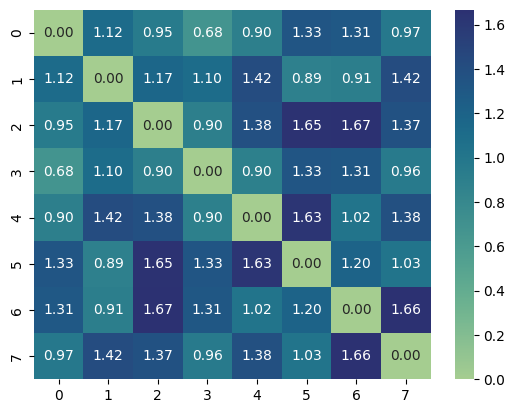

In [34]:
centroid_distance_matrix = squareform(pdist(kmeans.cluster_centers_))
sns.heatmap(centroid_distance_matrix, annot=True, fmt = '.2f', cmap='crest')
plt.show()

Construct matrix displaying correlation of attribute values to belonging to a certain cluster.

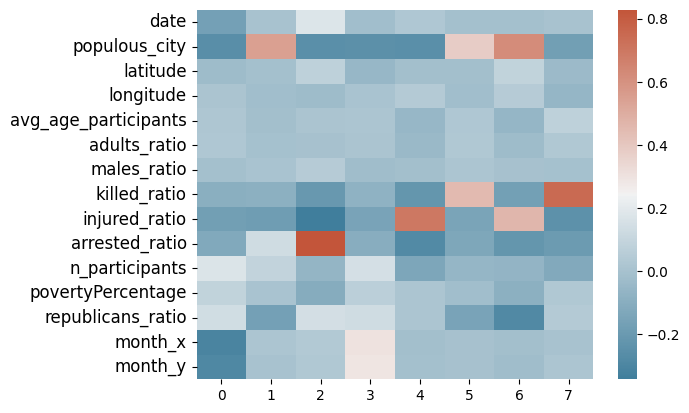

In [35]:
# Transfrom kmeans labels into onehot encoding
onehot = np.zeros((len(kmeans.labels_), n_clusters))
onehot[np.arange(len(kmeans.labels_)), kmeans.labels_] = 1

# Compute correlation between onehot encoding and scaled dataset
onehot_corr = np.corrcoef(scaled_dataset, onehot, rowvar=False)

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(onehot_corr[:scaled_dataset.shape[1], scaled_dataset.shape[1]:], cmap=cmap)

# Set ticks on y axis with feature names
plt.yticks(np.arange(scaled_dataset.shape[1]) + 0.5, dataset_reduced.columns, rotation=0, fontsize=12)
plt.show()

Compute the similarity matrix of a sample of the dataset.

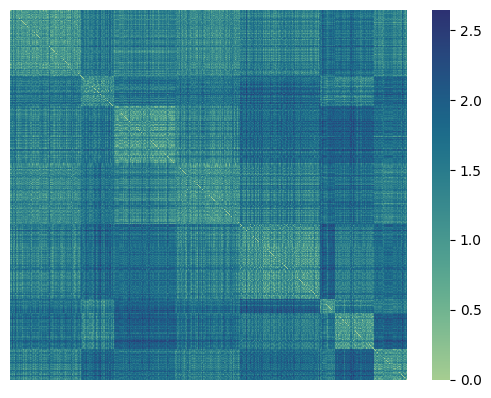

In [36]:
# Downsample the dataset to 10000
samples = np.random.choice(scaled_dataset.shape[0], 1000, replace=False)
downsampled_dataset = scaled_dataset[samples]
downsampled_labels = kmeans.labels_[samples]

# Sort based on labels
sorted_indexes = np.argsort(downsampled_labels)
downsampled_dataset = downsampled_dataset[sorted_indexes]
downsampled_labels = downsampled_labels[sorted_indexes]

# Compute similarity matrix
pdist_matrix = squareform(pdist(downsampled_dataset, metric='minkowski', p=2))
sns.heatmap(pdist_matrix, fmt = '.2f', cmap='crest')
plt.xticks([])
plt.yticks([])
plt.show()

In [37]:
kmeans.cluster_centers_.shape

(8, 15)

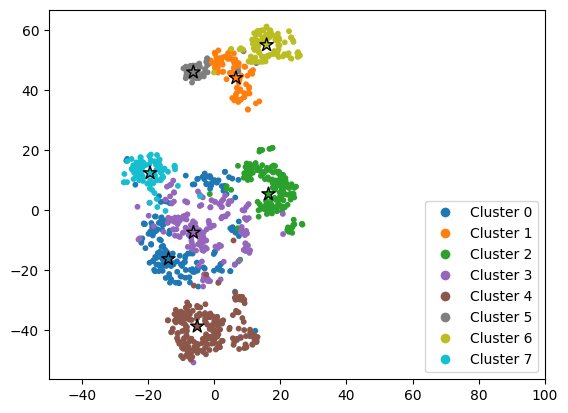

In [38]:
tsne = TSNE(n_components=2, n_jobs=-1)
tsne_dataset = np.concatenate((downsampled_dataset, kmeans.cluster_centers_))
tsne_labels = np.concatenate((downsampled_labels, range(n_clusters)))
tsne_map = tsne.fit_transform(tsne_dataset)

scatter = plt.scatter(tsne_map[:-n_clusters, 0], tsne_map[:-n_clusters, 1], c = tsne_labels[:-n_clusters], s=10, cmap='tab10')
plt.scatter(tsne_map[-n_clusters:, 0], tsne_map[-n_clusters:, 1], c = tsne_labels[-n_clusters:], s=100, cmap='tab10', marker='*', edgecolors='black')

# Get unique cluster labels
unique_labels = set(tsne_labels[:-n_clusters])

# Create a legend with a color for each cluster
legend_entries = []
for label in unique_labels:
    # Find the indices of data points with the current label
    indices = tsne_labels[:-n_clusters] == label
    # Add a legend entry for the current label with the corresponding color
    legend_entries.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8, label=f'Cluster {label}'))

# Add legend to the plot
plt.legend(handles=legend_entries, loc='lower right')
plt.xlim(-50,100)
plt.show()

## 2.3 Distribution of variables: within clusters vs whole dataset

Analysis of distribution of repubblican vs democrats in the clusters.

In [147]:
party_xt_pct = pd.crosstab(kmeans.labels_, dataset_reduced['republicans_ratio'] > 0.5)
party_xt_pct

republicans_ratio,False,True
row_0,,
0,16086,19308
1,15917,2742
2,16043,18960
3,15370,18516
4,20388,14866
5,8501,1041
6,21547,1719
7,9812,8848


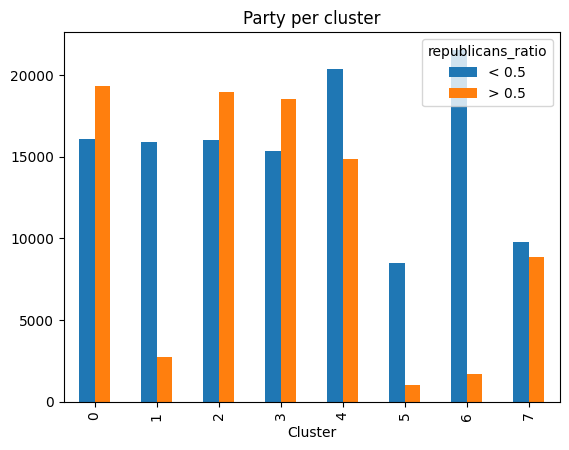

In [148]:
party_xt_pct.plot(kind='bar', stacked=False, 
                   title='Party per cluster')
plt.xlabel('Cluster')

# Set in the legend republicans_ratio >0.5 and <0.5
plt.legend(['< 0.5', '> 0.5'], loc='upper right', title = 'republicans_ratio')

plt.show()

In [149]:

populous_city_xt_pct = pd.crosstab(kmeans.labels_, dataset_reduced['populous_city'])
populous_city_xt_pct

populous_city,0,1
row_0,,
0,35394,0
1,0,18659
2,35003,0
3,33886,0
4,35254,0
5,0,9542
6,0,23266
7,18660,0


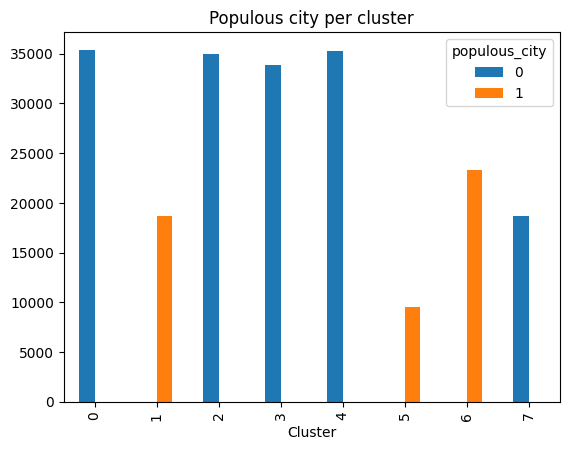

In [150]:
populous_city_xt_pct.plot(kind='bar', stacked=False, 
                   title='Populous city per cluster')
plt.xlabel('Cluster')
plt.show()

Let's explore some continuous variables, such as the arrested ratio, and look at clusters positively and negatively correlated to that variable. We can see that the distributions are very different amongst the two clusters, and they represent different trends which are present in the full distribution.

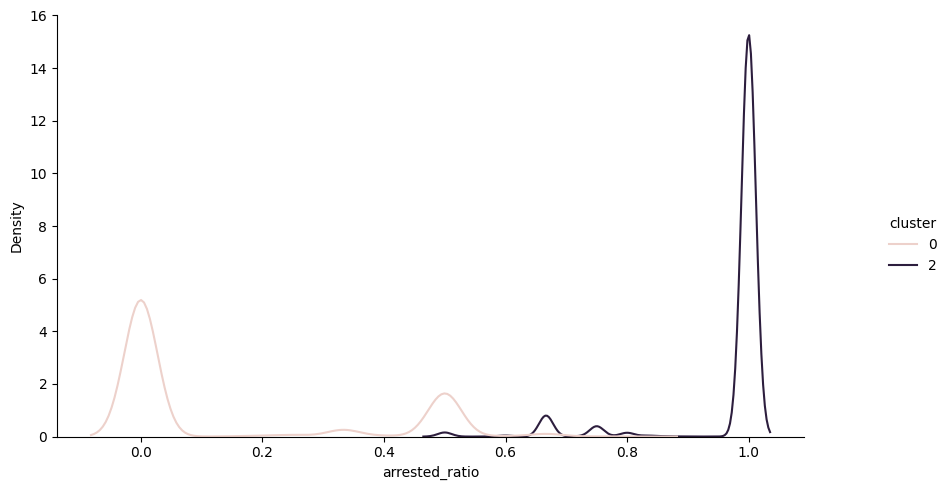

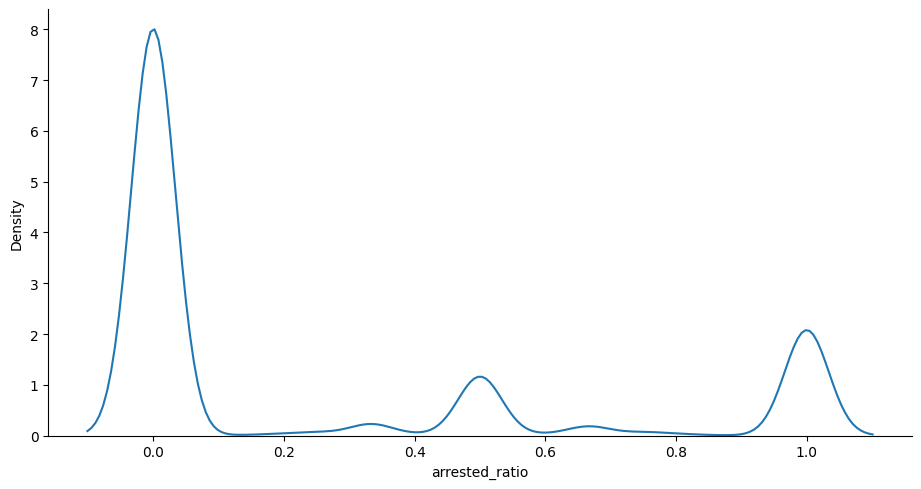

In [63]:
# Plot distribution of average age for whole dataset and clusters
arrested_analysis = [0,2]
dataset_reduced_with_clusters = dataset_reduced.copy()
dataset_reduced_with_clusters['cluster'] = kmeans.labels_
dataset_reduced_with_clusters_picked = dataset_reduced_with_clusters[(dataset_reduced_with_clusters['cluster'] == arrested_analysis[0]) | \
                                                              (dataset_reduced_with_clusters['cluster'] == arrested_analysis[1]) ]  

sns.displot(dataset_reduced_with_clusters_picked, x="arrested_ratio", kind='kde', hue="cluster")
plt.gcf().set_size_inches(10, 5)

sns.displot(dataset_reduced_with_clusters, x="arrested_ratio", kind='kde')
plt.gcf().set_size_inches(10, 5)
plt.show()


# 3. DBSCAN

## 3.1 Identification of best eps value

In [64]:
k = 5
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree', n_jobs=-1).fit(scaled_dataset_florida)
distances, indices = nbrs.kneighbors(scaled_dataset_florida)
kth_distances = distances[:, k]
distances.shape

(13262, 6)

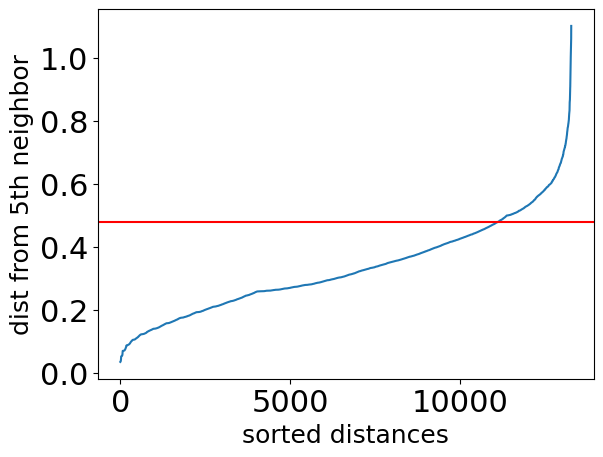

In [65]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.axhline(y = 0.48, color = 'r')
plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
plt.xlabel('sorted distances', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

## 3.2 Cluster Analysis

In [79]:
dbscan = DBSCAN(eps=0.48, min_samples=100)
dbscan.fit(scaled_dataset_florida)
labels, cluster_num_points = np.unique(dbscan.labels_, return_counts=True)
n_clusters = len(labels)
cluster_num_points

array([8215, 1893, 1322, 1832])

In [80]:
cluster_points = []
for i in range(n_clusters):
    cluster_points.append(scaled_dataset_florida[dbscan.labels_ == i-1])

In [81]:
print('Silhouette %s' % silhouette_score(scaled_dataset_florida, dbscan.labels_))
print('Davies-Bouldin %s' % davies_bouldin_score(scaled_dataset_florida, dbscan.labels_))

Silhouette 0.014617068953467975
Davies-Bouldin 2.605966647562307


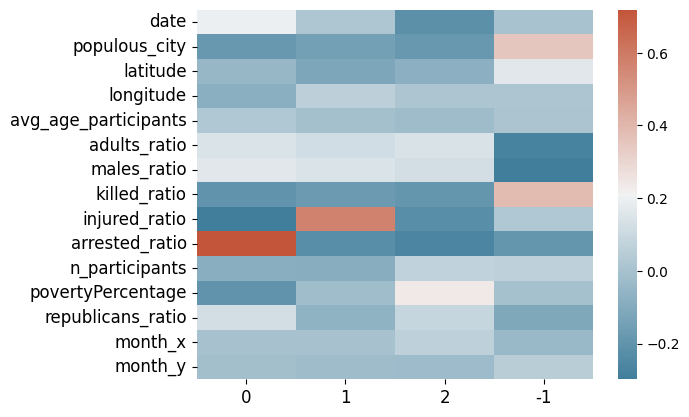

In [82]:
# Transfrom kmeans labels into onehot encoding
onehot = np.zeros((len(dbscan.labels_), n_clusters))
onehot[np.arange(len(dbscan.labels_)), dbscan.labels_] = 1

# Compute correlation between onehot encoding and scaled dataset
onehot_corr = np.corrcoef(scaled_dataset_florida, onehot, rowvar=False)

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(onehot_corr[:scaled_dataset_florida.shape[1], scaled_dataset_florida.shape[1]:], fmt = '.2f', cmap=cmap)

# Set ticks on y axis with feature names
plt.yticks(np.arange(scaled_dataset_florida.shape[1]) + 0.5, dataset_reduced_florida.columns, rotation=0, fontsize=12)

# Set ticks on x axis with cluster names
x_ticks = np.append(np.arange(n_clusters - 1), -1)
plt.xticks(np.arange(n_clusters) + 0.5, x_ticks, rotation=0, fontsize=12)

plt.show()

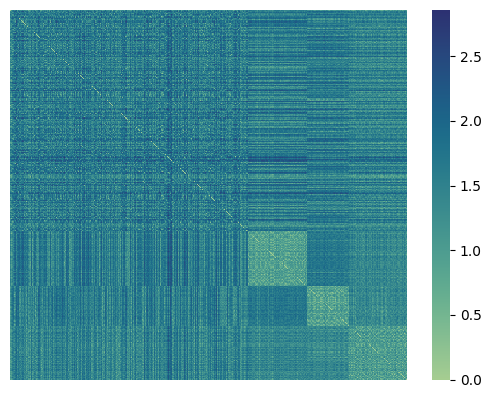

In [83]:
# Downsample the dataset to 10000
samples = np.random.choice(scaled_dataset_florida.shape[0], 1000, replace=False)
downsampled_dataset = scaled_dataset_florida[samples]
downsampled_labels = dbscan.labels_[samples]

# Sort based on labels
sorted_indexes = np.argsort(downsampled_labels)
downsampled_dataset = downsampled_dataset[sorted_indexes]
downsampled_labels = downsampled_labels[sorted_indexes]

# Compute similarity matrix
pdist_matrix = squareform(pdist(downsampled_dataset, metric='minkowski', p=2))
sns.heatmap(pdist_matrix, fmt = '.2f', cmap='crest')
plt.xticks([])
plt.yticks([])
plt.show()

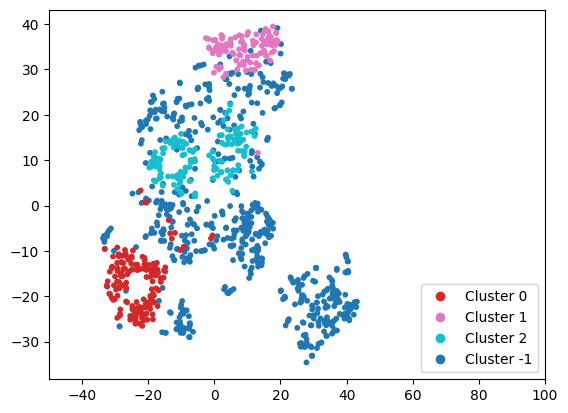

In [84]:
tsne = TSNE(n_components=2, n_jobs=-1)
tsne_map = tsne.fit_transform(downsampled_dataset)

scatter = plt.scatter(tsne_map[:, 0], tsne_map[:, 1], c = downsampled_labels, s=10, cmap='tab10')

unique_labels = set(downsampled_labels)

# Create a legend with a color for each cluster
legend_entries = []
for label in unique_labels:
    # Find the indices of data points with the current label
    indices = downsampled_labels == label
    # Add a legend entry for the current label with the corresponding color
    legend_entries.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8, label=f'Cluster {label}'))

# Add legend to the plot
plt.legend(handles=legend_entries, loc='lower right')
plt.xlim(-50,100)
plt.show()

## 3.3 Distribution of variables: within clusters vs whole dataset

Analysis of distribution of repubblican vs democrats in the clusters.

In [151]:
party_xt_pct = pd.crosstab(dbscan.labels_, dataset_reduced_florida['republicans_ratio'] > 0.5)
party_xt_pct

republicans_ratio,False,True
row_0,,
-1,4443,3772
0,575,1318
1,727,595
2,742,1090


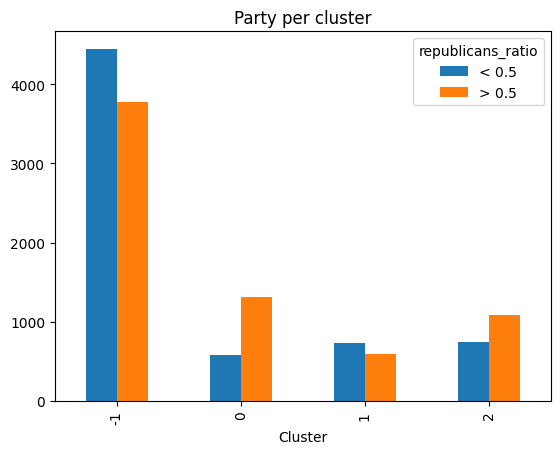

In [152]:
party_xt_pct.plot(kind='bar', stacked=False, 
                   title='Party per cluster')
plt.xlabel('Cluster')

# Set in the legend republicans_ratio >0.5 and <0.5
plt.legend(['< 0.5', '> 0.5'], loc='upper right', title = 'republicans_ratio')

plt.show()

In [153]:

populous_city_xt_pct = pd.crosstab(dbscan.labels_, dataset_reduced_florida['populous_city'])
populous_city_xt_pct

populous_city,0,1
row_0,,
-1,5994,2221
0,1893,0
1,1322,0
2,1832,0


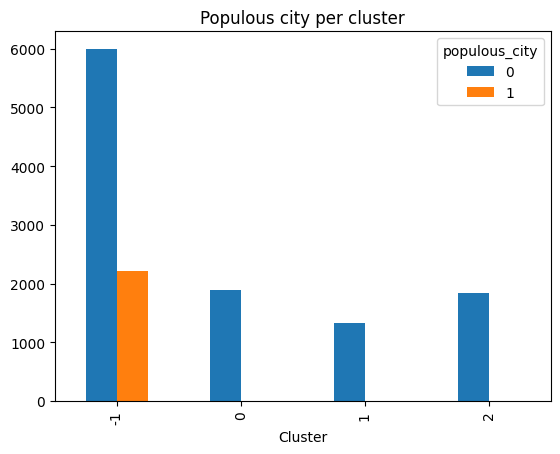

In [154]:
populous_city_xt_pct.plot(kind='bar', stacked=False, 
                   title='Populous city per cluster')
plt.xlabel('Cluster')
plt.show()

Let's explore some continuous variables, such as the arrested ratio, and look at clusters positively and negatively correlated to that variable. We can see that the distributions are very different amongst the two clusters, and they represent different trends which are present in the full distribution.

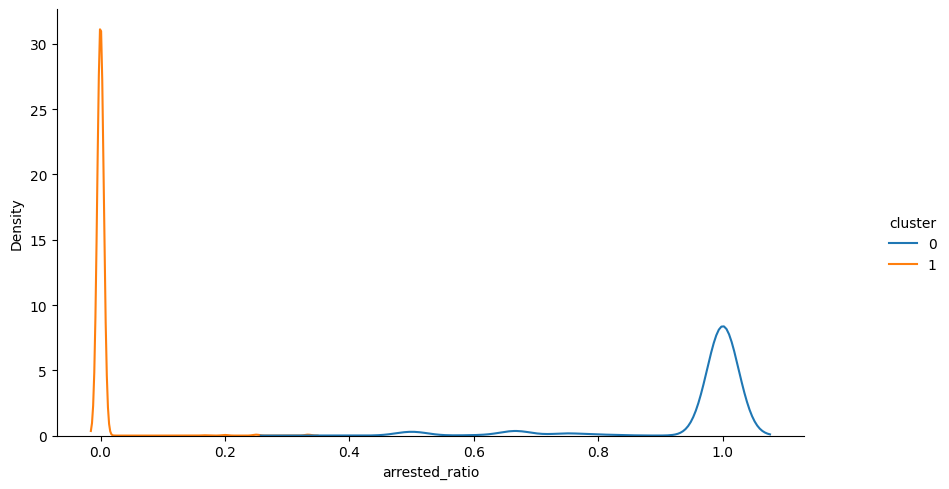

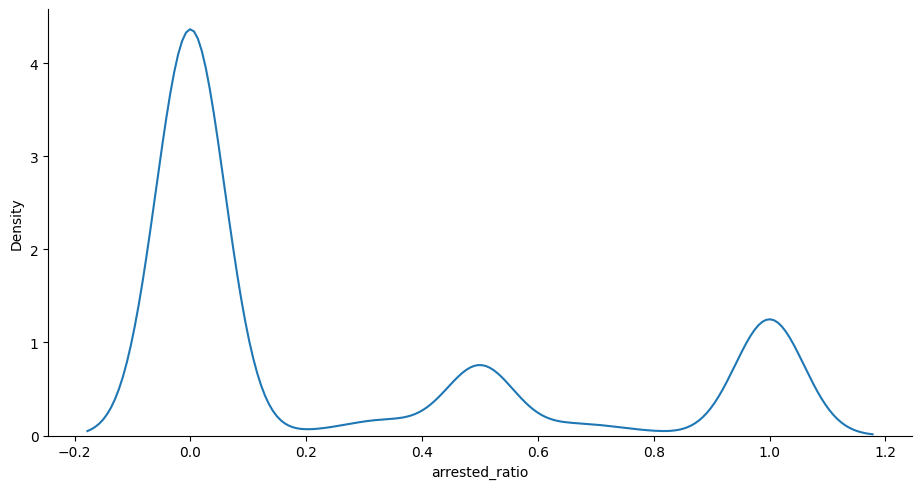

In [90]:
# Plot distribution of average age for whole dataset and clusters
arrested_analysis = [0, 1]
dataset_reduced_florida_with_clusters = dataset_reduced_florida.copy()
dataset_reduced_florida_with_clusters['cluster'] = dbscan.labels_
dataset_reduced_florida_with_clusters_picked = dataset_reduced_florida_with_clusters[(dataset_reduced_florida_with_clusters['cluster'] == arrested_analysis[0]) | \
                                                              (dataset_reduced_florida_with_clusters['cluster'] == arrested_analysis[1]) ]  

sns.displot(dataset_reduced_florida_with_clusters_picked, x="arrested_ratio", kind='kde', hue="cluster")
plt.gcf().set_size_inches(10, 5)

sns.displot(dataset_reduced_florida_with_clusters, x="arrested_ratio", kind='kde')
plt.gcf().set_size_inches(10, 5)
plt.show()


# 4 Hierarchical clustering

## 4.1 Identification of best linkage technique

In [91]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [92]:
linkages = ["single", "complete", "average", "ward"]
hierarchical_results = []
for linkage in linkages:
    hierarchical_clustering = AgglomerativeClustering(linkage=linkage, distance_threshold=0, n_clusters=None)
    hierarchical_clustering.fit(scaled_dataset_florida)
    hierarchical_results.append(hierarchical_clustering)

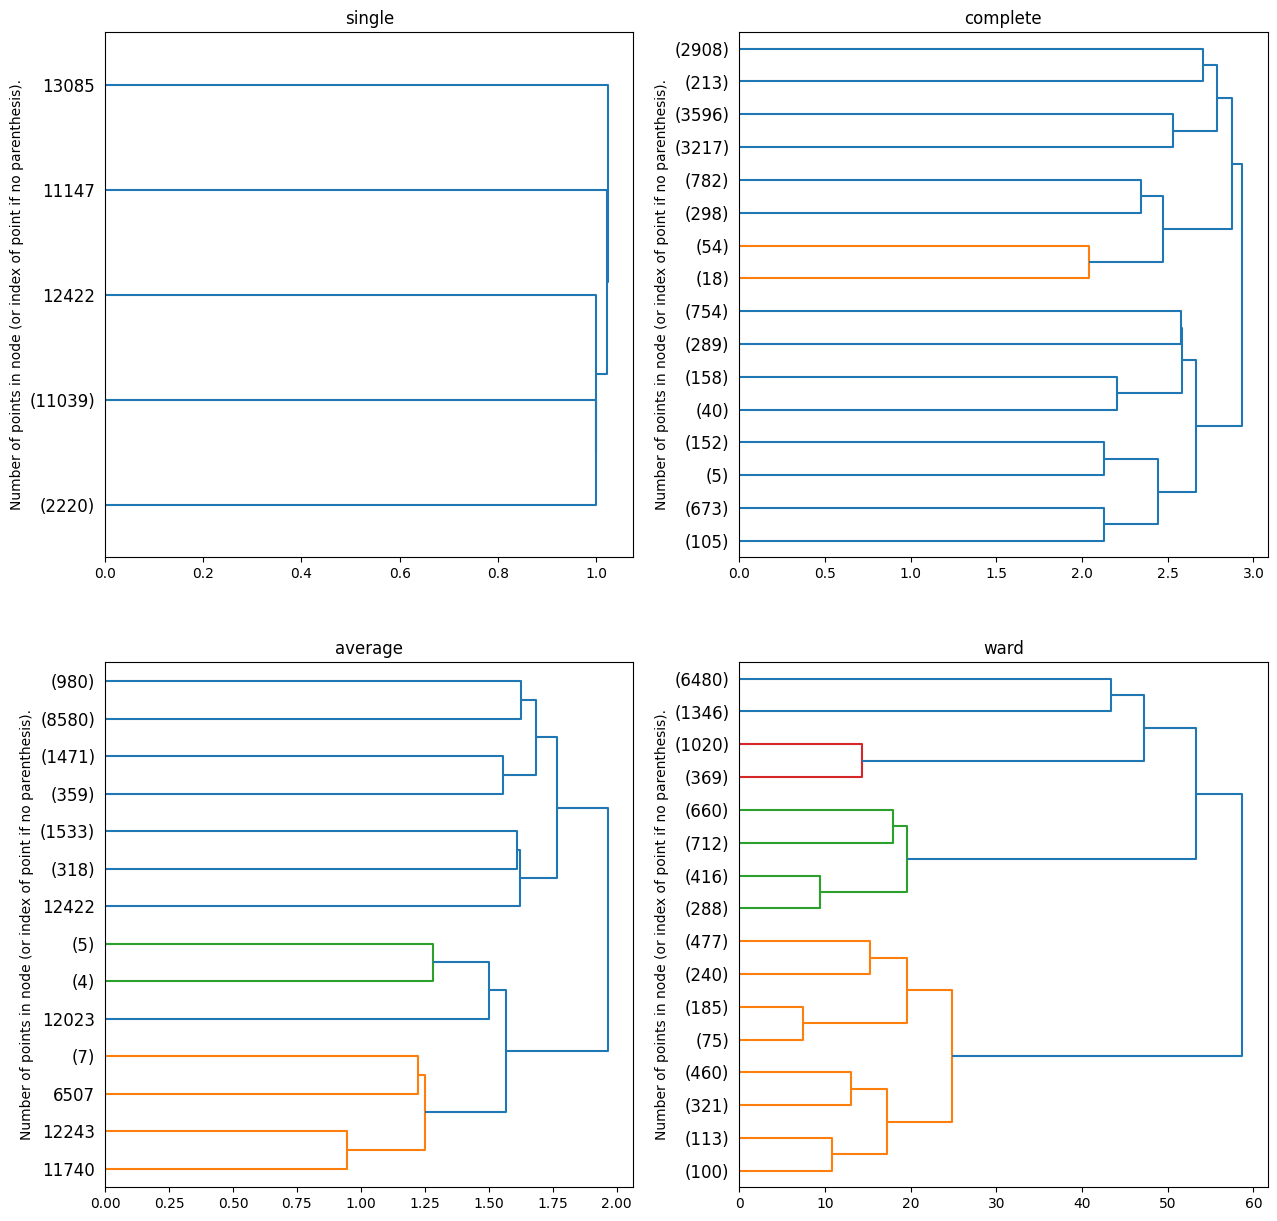

In [93]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
for i, (linkage, model) in enumerate(zip(linkages, hierarchical_results)):
    # plot the top three levels of the dendrogram
    ax[i // 2][i % 2].set_title(linkage)
    plot_dendrogram(model, truncate_mode="level", p=3, ax=ax[i // 2][i % 2], orientation="right")
    ax[i // 2][i % 2].set_ylabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Ward is the unique linkage technique that yield well separeted clusters, even if with a slighly unbalanced cluster (that is reasonable considering the dataset)

## 4.2 Identification of best value of k

In [94]:
def calculate_sse(labels):
    n_cluster = len(np.unique(labels))
    global_sse = 0
    for i in range(n_cluster): # for each cluster
        cluster_points = scaled_dataset_florida[labels == i]
        centroid = np.mean(cluster_points, axis=0)
        # calculate the sse for the single cluster
        current_sse = 0
        for p in cluster_points:
            current_sse += np.linalg.norm( np.subtract(p, centroid)) ** 2

        global_sse += current_sse
    return global_sse

In [95]:
sse_list = []
silhoutte_list = []
davies_bouldin_list = []

max_k = 20
for k in tqdm(range(2, max_k + 1), ):
    hierarchical_clustering = AgglomerativeClustering(n_clusters=k, linkage="ward")
    hierarchical_clustering.fit(scaled_dataset_florida)

    sse_list.append(calculate_sse(hierarchical_clustering.labels_))
    silhoutte_list.append(silhouette_score(scaled_dataset_florida, hierarchical_clustering.labels_))
    davies_bouldin_list.append(davies_bouldin_score(scaled_dataset_florida, hierarchical_clustering.labels_))


100%|██████████| 19/19 [02:36<00:00,  8.25s/it]


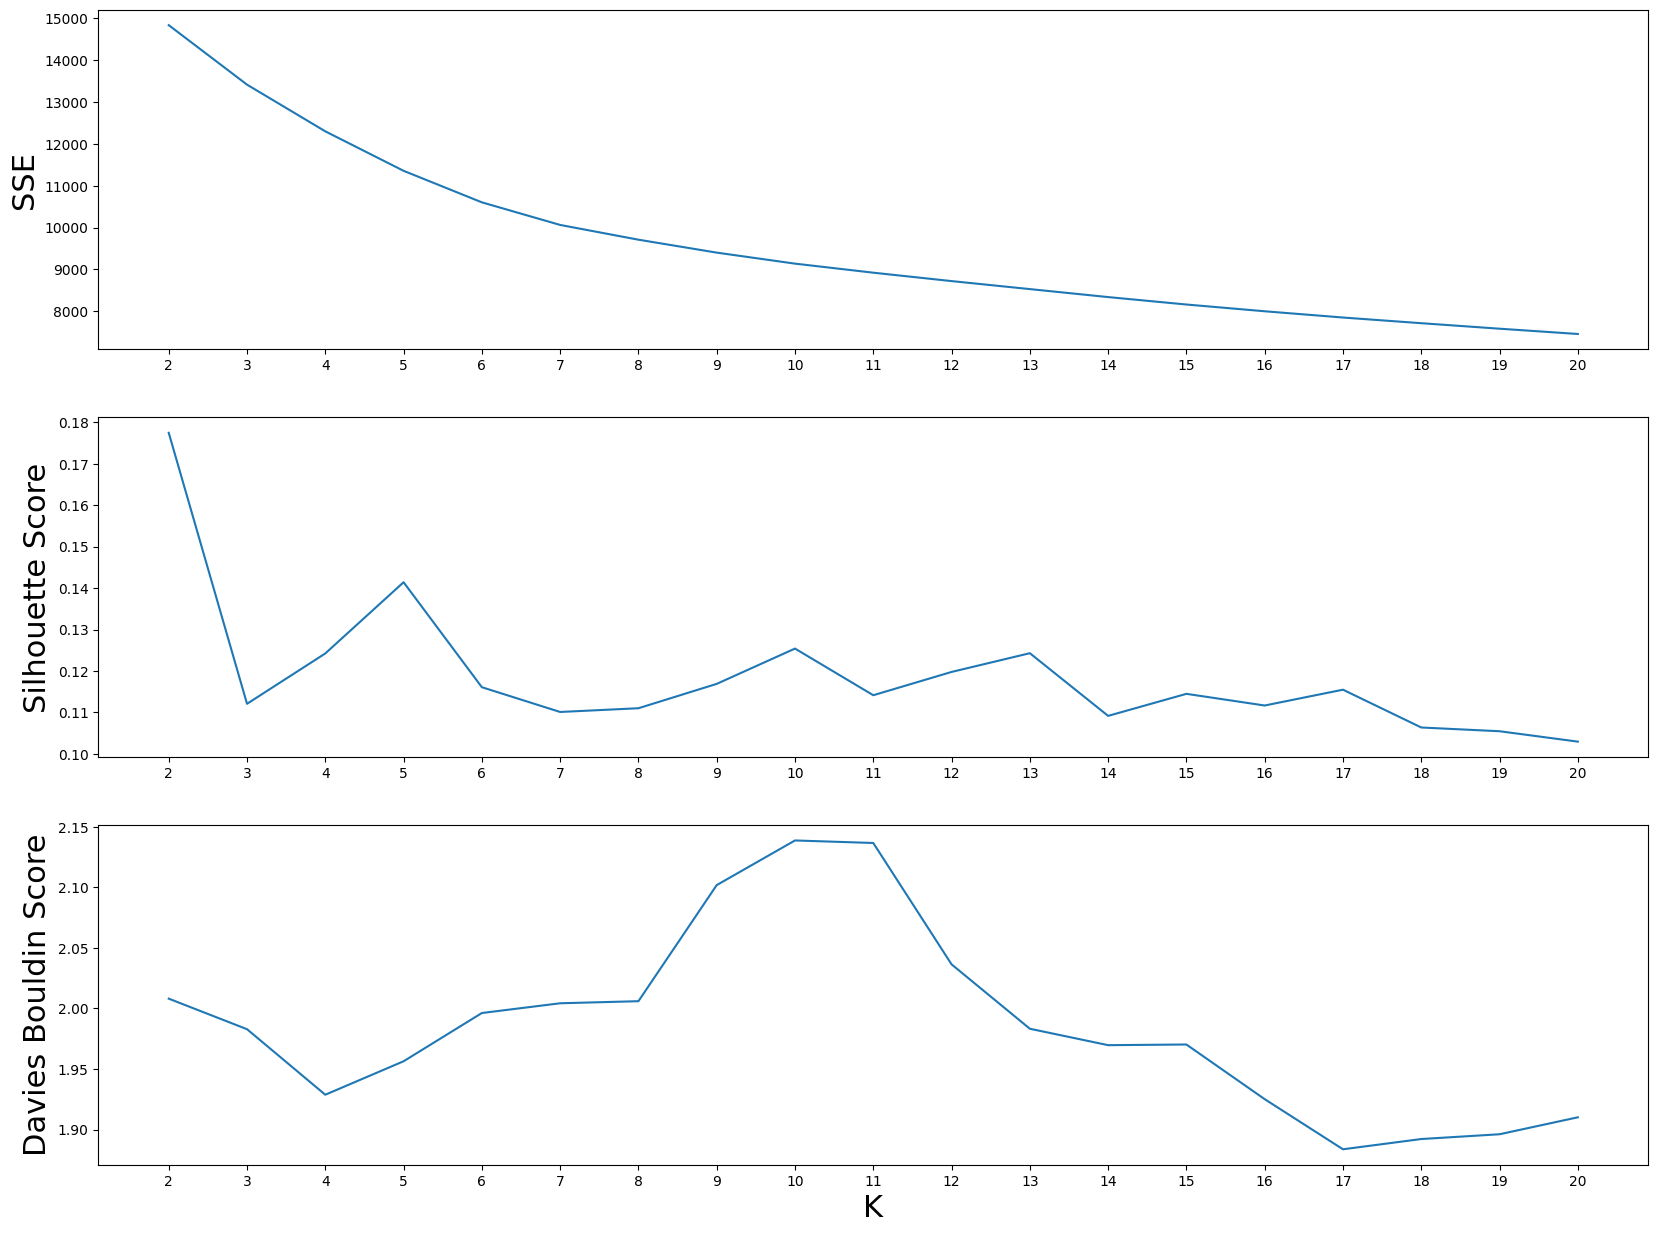

In [103]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list) + 2), sse_list)
ax[0].set_ylabel('SSE', fontsize=22)
ax[0].set_xticks(range(2, len(sse_list) + 2))

ax[1].plot(range(2, len(silhoutte_list) + 2), silhoutte_list)
ax[1].set_ylabel('Silhouette Score', fontsize=22)
ax[1].set_xticks(range(2, len(sse_list) + 2))

ax[2].plot(range(2, len(davies_bouldin_list) + 2), davies_bouldin_list)
ax[2].set_xlabel('K', fontsize=22)
ax[2].set_ylabel('Davies Bouldin Score', fontsize=22)
ax[2].set_xticks(range(2, len(sse_list) + 2))


plt.xlabel('K', fontsize=22)
plt.show()

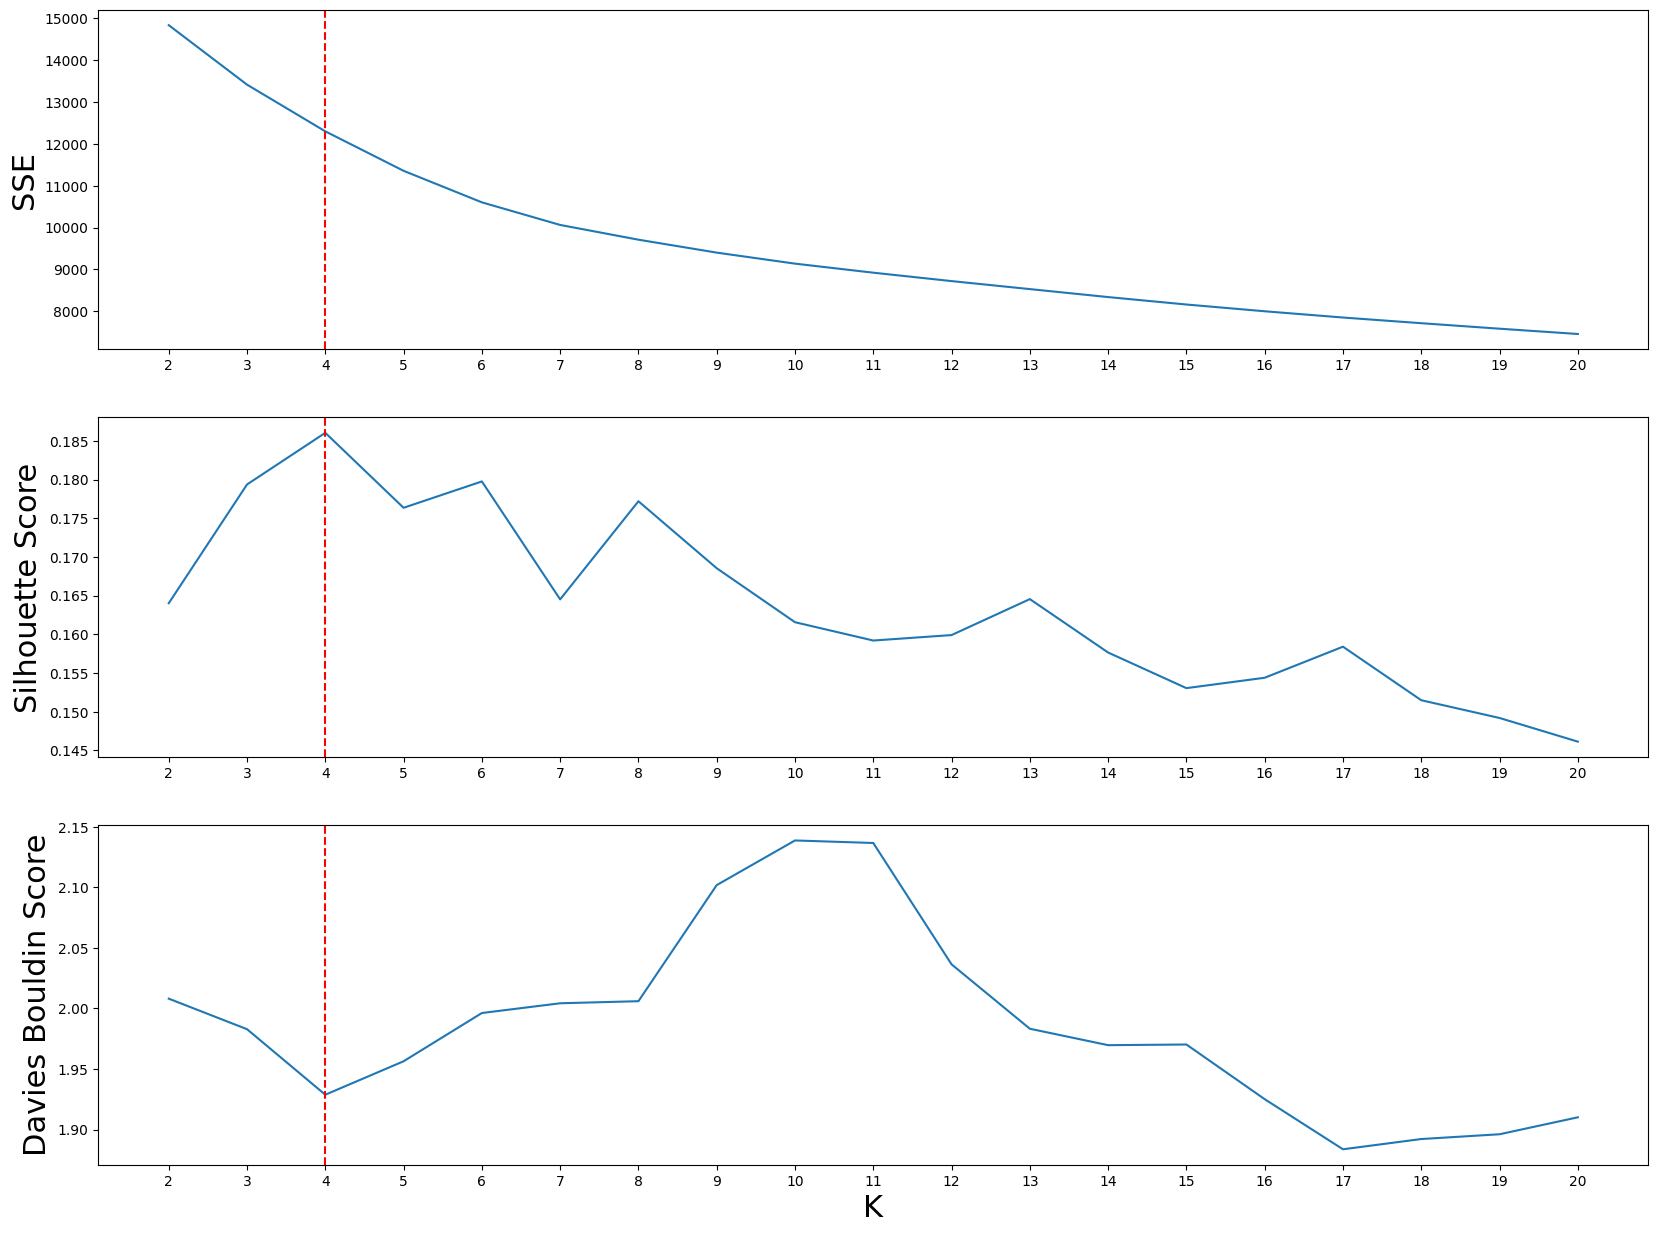

In [105]:
CHOSEN_K = 4

fig, ax = plt.subplots(3, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list) + 2), sse_list)
ax[0].set_ylabel('SSE', fontsize=22)
ax[0].set_xticks(range(2, len(sse_list) + 2))

ax[1].plot(range(2, len(silhouette_list) + 2), silhouette_list)
ax[1].set_ylabel('Silhouette Score', fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list) + 2))

ax[2].plot(range(2, len(davies_bouldin_list) + 2), davies_bouldin_list)
ax[2].set_ylabel('Davies Bouldin Score', fontsize=22)
ax[2].set_xticks(range(2, len(davies_bouldin_list) + 2))

# set a vertical line on all three subplots at x = CHOSEN_K
for i in range(3):
    ax[i].axvline(x=CHOSEN_K, color='r', linestyle='--')

plt.xlabel('K', fontsize=22)
plt.show()

## 4.3 Analysis of the centroids and clusters

In [106]:
n_clusters = CHOSEN_K
hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
hierarchical_clustering.fit(scaled_dataset_florida)

AgglomerativeClustering(n_clusters=4)

In [108]:
cluster_points = []
for i in range(n_clusters):
    cluster_points.append(scaled_dataset_florida[hierarchical_clustering.labels_ == i])

In [109]:
print('Silhouette %s' % silhouette_score(scaled_dataset_florida, hierarchical_clustering.labels_))
print('Davies-Bouldin %s' % davies_bouldin_score(scaled_dataset_florida, hierarchical_clustering.labels_))

Silhouette 0.12424103834919674
Davies-Bouldin 1.9288064014149124


In [110]:
hierarchical_centroids = [np.mean(scaled_dataset_florida[hierarchical_clustering.labels_ == i], axis=0) for i in range(n_clusters)]
hierarchical_centroids[0].shape

(15,)

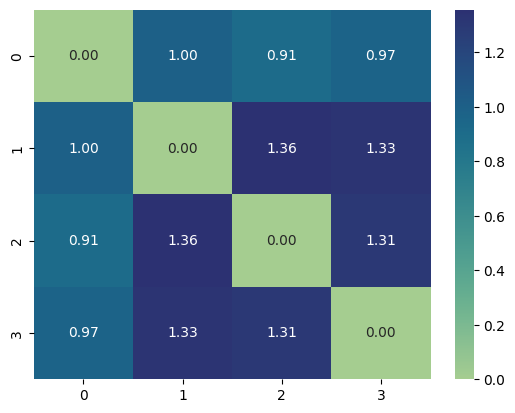

In [111]:
centroid_distance_matrix = squareform(pdist(hierarchical_centroids))
sns.heatmap(centroid_distance_matrix, annot=True, fmt = '.2f', cmap='crest')
plt.show()

Construct matrix displaying correlation of attribute values to belonging to a certain cluster.

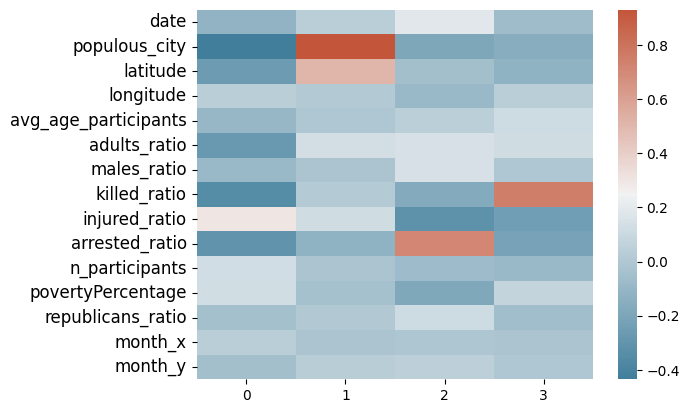

In [112]:
# Transfrom kmeans labels into onehot encoding
onehot = np.zeros((len(hierarchical_clustering.labels_), n_clusters))
onehot[np.arange(len(hierarchical_clustering.labels_)), hierarchical_clustering.labels_] = 1

# Compute correlation between onehot encoding and scaled dataset
onehot_corr = np.corrcoef(scaled_dataset_florida, onehot, rowvar=False)

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(onehot_corr[:scaled_dataset_florida.shape[1], scaled_dataset_florida.shape[1]:], cmap=cmap)

# Set ticks on y axis with feature names
plt.yticks(np.arange(scaled_dataset_florida.shape[1]) + 0.5, dataset_reduced_florida.columns, rotation=0, fontsize=12)
plt.show()

Compute the similarity matrix of a sample of the dataset.

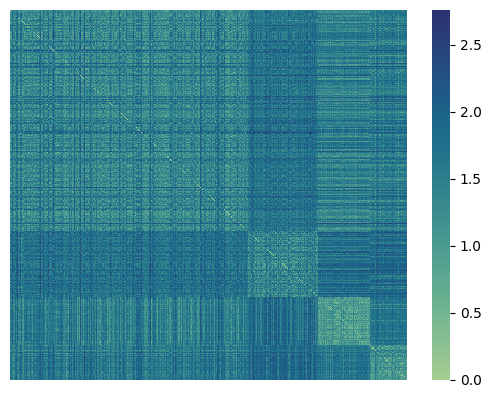

In [113]:
# Downsample the dataset to 10000
samples = np.random.choice(scaled_dataset_florida.shape[0], 1000, replace=False)
downsampled_dataset = scaled_dataset_florida[samples]
downsampled_labels = hierarchical_clustering.labels_[samples]

# Sort based on labels
sorted_indexes = np.argsort(downsampled_labels)
downsampled_dataset = downsampled_dataset[sorted_indexes]
downsampled_labels = downsampled_labels[sorted_indexes]

# Compute similarity matrix
pdist_matrix = squareform(pdist(downsampled_dataset, metric='minkowski', p=2))
sns.heatmap(pdist_matrix, fmt = '.2f', cmap='crest')
plt.xticks([])
plt.yticks([])
plt.show()

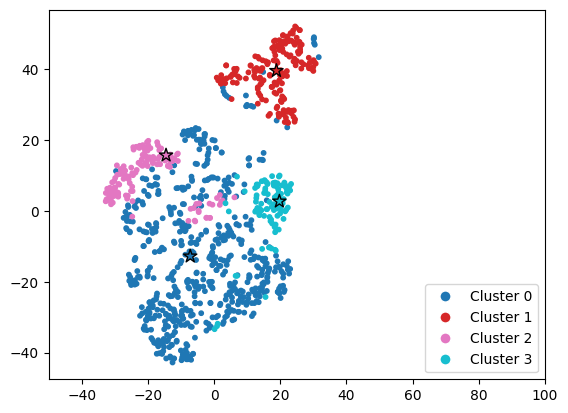

In [114]:
tsne = TSNE(n_components=2, n_jobs=-1)
tsne_dataset = np.concatenate((downsampled_dataset, hierarchical_centroids))
tsne_labels = np.concatenate((downsampled_labels, range(n_clusters)))
tsne_map = tsne.fit_transform(tsne_dataset)

scatter = plt.scatter(tsne_map[:-n_clusters, 0], tsne_map[:-n_clusters, 1], c = tsne_labels[:-n_clusters], s=10, cmap='tab10')
plt.scatter(tsne_map[-n_clusters:, 0], tsne_map[-n_clusters:, 1], c = tsne_labels[-n_clusters:], s=100, cmap='tab10', marker='*', edgecolors='black')

# Get unique cluster labels
unique_labels = set(tsne_labels[:-n_clusters])

# Create a legend with a color for each cluster
legend_entries = []
for label in unique_labels:
    # Find the indices of data points with the current label
    indices = tsne_labels[:-n_clusters] == label
    # Add a legend entry for the current label with the corresponding color
    legend_entries.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8, label=f'Cluster {label}'))

# Add legend to the plot
plt.legend(handles=legend_entries, loc='lower right')
plt.xlim(-50,100)
plt.show()

## 4.4 Distribution of variables: within clusters vs whole dataset

Analysis of distribution of repubblican vs democrats in the clusters.

In [155]:
party_xt_pct = pd.crosstab(hierarchical_clustering.labels_, dataset_reduced_florida['republicans_ratio'] > 0.5)
party_xt_pct

republicans_ratio,False,True
row_0,,
0,3817,4009
1,1237,734
2,688,1388
3,745,644


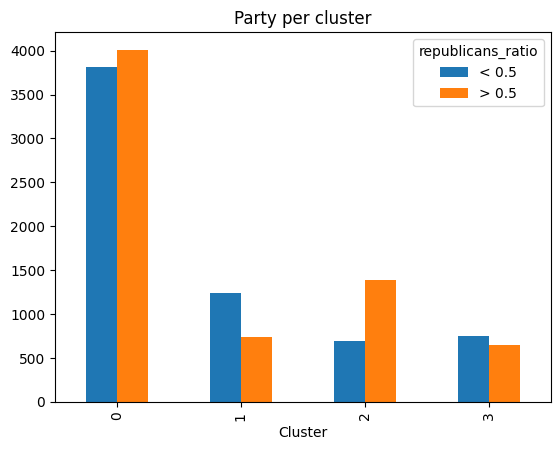

In [156]:
party_xt_pct.plot(kind='bar', stacked=False, 
                   title='Party per cluster')
plt.xlabel('Cluster')

# Set in the legend republicans_ratio >0.5 and <0.5
plt.legend(['< 0.5', '> 0.5'], loc='upper right', title = 'republicans_ratio')

plt.show()

In [157]:

populous_city_xt_pct = pd.crosstab(hierarchical_clustering.labels_, dataset_reduced_florida['populous_city'])
populous_city_xt_pct

populous_city,0,1
row_0,,
0,7576,250
1,0,1971
2,2076,0
3,1389,0


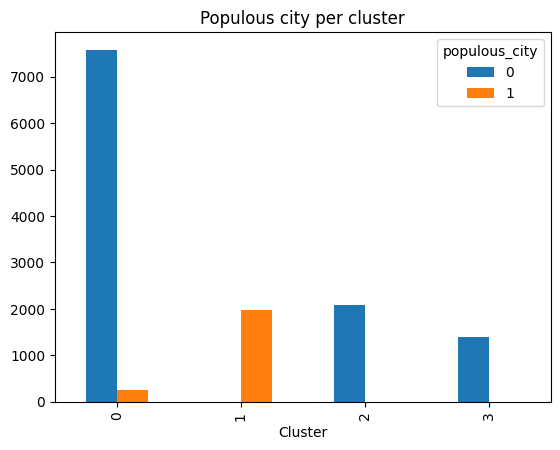

In [158]:
populous_city_xt_pct.plot(kind='bar', stacked=False, 
                   title='Populous city per cluster')
plt.xlabel('Cluster')
plt.show()

Let's explore some continuous variables, such as the arrested ratio, and look at clusters positively and negatively correlated to that variable. We can see that the distributions are very different amongst the two clusters, and they represent different trends which are present in the full distribution.

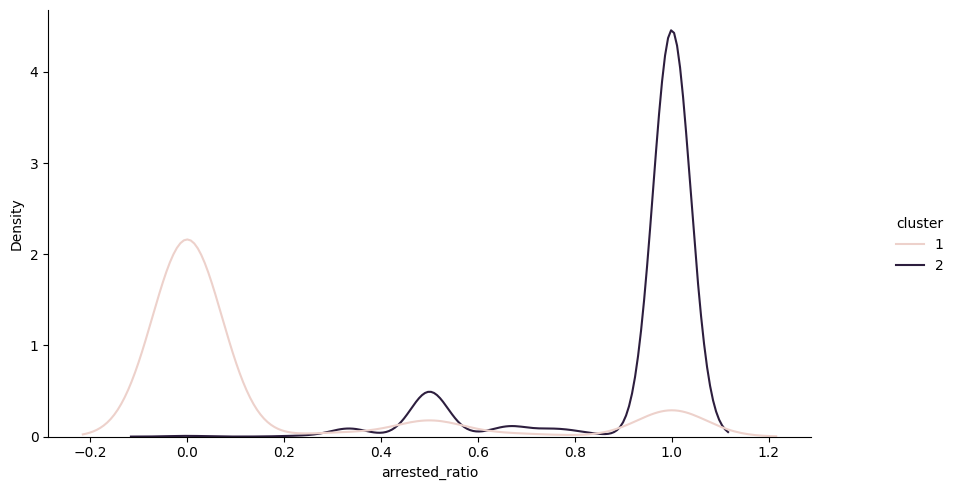

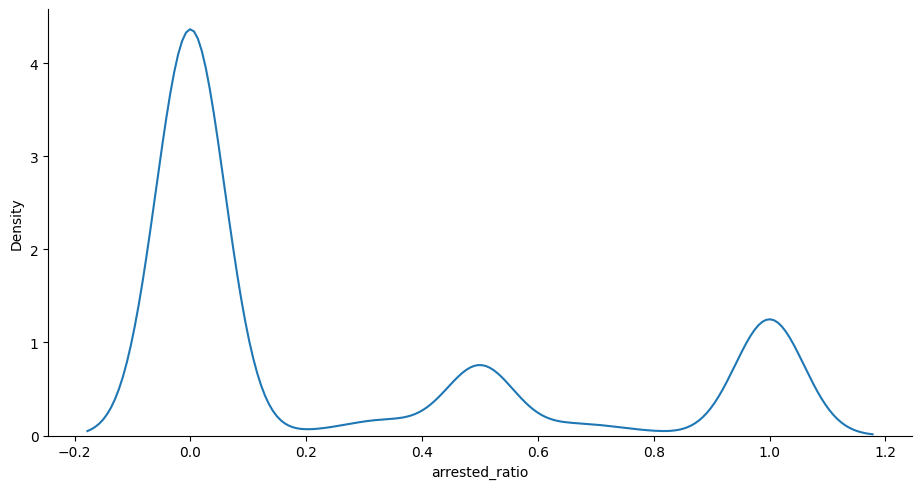

In [135]:
# Plot distribution of average age for whole dataset and clusters
arrested_analysis = [1, 2]
dataset_reduced_with_clusters = dataset_reduced_florida.copy()
dataset_reduced_with_clusters['cluster'] = hierarchical_clustering.labels_
dataset_reduced_with_clusters_picked = dataset_reduced_with_clusters[(dataset_reduced_with_clusters['cluster'] == arrested_analysis[0]) | \
                                                              (dataset_reduced_with_clusters['cluster'] == arrested_analysis[1]) ]  

sns.displot(dataset_reduced_with_clusters_picked, x="arrested_ratio", kind='kde', hue="cluster")
plt.gcf().set_size_inches(10, 5)

sns.displot(dataset_reduced_with_clusters, x="arrested_ratio", kind='kde')
plt.gcf().set_size_inches(10, 5)
plt.show()


# 5 Xmeans

In [136]:
def calculate_sse(labels):
    n_cluster = len(np.unique(labels))
    global_sse = 0
    for i in range(n_cluster): # for each cluster
        cluster_points = scaled_dataset[labels == i]
        centroid = np.mean(cluster_points, axis=0)
        # calculate the sse for the single cluster
        current_sse = 0
        for p in cluster_points:
            current_sse += np.linalg.norm( np.subtract(p, centroid)) ** 2

        global_sse += current_sse
    return global_sse
sse_list = []
silhoutte_list = []
davies_bouldin_list = []

In [137]:
def clusters_to_labels(clusters):
    labels = np.zeros(scaled_dataset.shape[0], dtype=int)
    for i in range(len(clusters)):
        labels[clusters[i]] = i
    return labels

In [138]:
initial_centers = kmeans_plusplus_initializer(scaled_dataset, 3).initialize()

xmeans_clustering = xmeans(scaled_dataset, initial_centers, 10)
xmeans_clustering.process()

xmeans_labels = clusters_to_labels(xmeans_clustering.get_clusters())
print(np.unique(xmeans_labels, return_counts=True))
n_clusters = np.unique(xmeans_labels).shape[0]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([19694,  6546, 29243, 18787, 36552,  8447, 28832, 18125, 32062,
       11376]))


## 5.2 Analysis of the centroids and clusters

In [139]:
print('Silhouette %s' % silhouette_score(scaled_dataset, xmeans_labels, sample_size=10000))
print('Davies-Bouldin %s' % davies_bouldin_score(scaled_dataset, xmeans_labels))

Silhouette 0.16190325156489244
Davies-Bouldin 1.8025522780581464


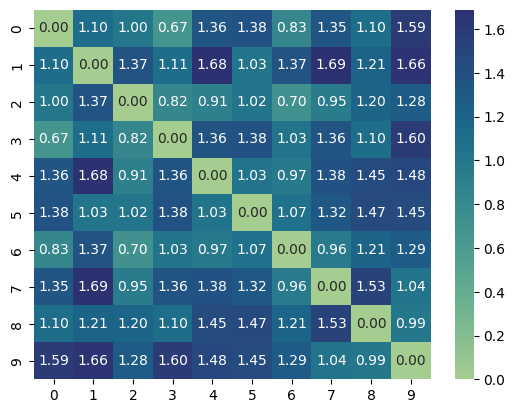

In [140]:
xmeans_centroids = [np.mean(scaled_dataset[xmeans_labels == i], axis=0) for i in range(n_clusters)]
xmeans_centroids[0].shape
centroid_distance_matrix = squareform(pdist(xmeans_centroids))
sns.heatmap(centroid_distance_matrix, annot=True, fmt = '.2f', cmap='crest')
plt.show()

Construct matrix displaying correlation of attribute values to belonging to a certain cluster.

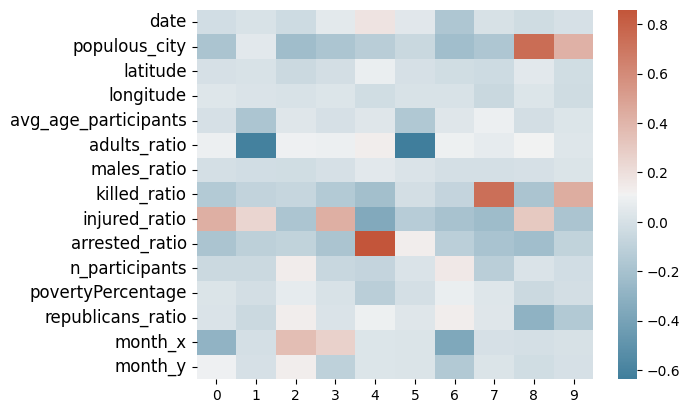

In [141]:
# Transfrom kmeans labels into onehot encoding
onehot = np.zeros((len(xmeans_labels), n_clusters))
onehot[np.arange(len(xmeans_labels)), xmeans_labels] = 1

# Compute correlation between onehot encoding and scaled dataset
onehot_corr = np.corrcoef(scaled_dataset, onehot, rowvar=False)

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(onehot_corr[:scaled_dataset.shape[1], scaled_dataset.shape[1]:], cmap=cmap)

# Set ticks on y axis with feature names
plt.yticks(np.arange(scaled_dataset.shape[1]) + 0.5, dataset_reduced.columns, rotation=0, fontsize=12)
plt.show()

Compute the similarity matrix of a sample of the dataset.

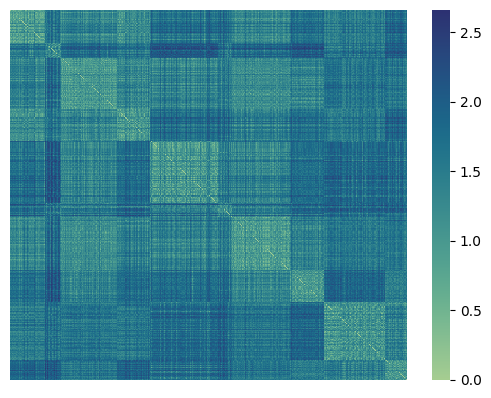

In [142]:
# Downsample the dataset to 10000
samples = np.random.choice(scaled_dataset.shape[0], 1000, replace=False)
downsampled_dataset = scaled_dataset[samples]
downsampled_labels = xmeans_labels[samples]

# Sort based on labels
sorted_indexes = np.argsort(downsampled_labels)
downsampled_dataset = downsampled_dataset[sorted_indexes]
downsampled_labels = downsampled_labels[sorted_indexes]

# Compute similarity matrix
pdist_matrix = squareform(pdist(downsampled_dataset, metric='minkowski', p=2))
sns.heatmap(pdist_matrix, fmt = '.2f', cmap='crest')
plt.xticks([])
plt.yticks([])
plt.show()

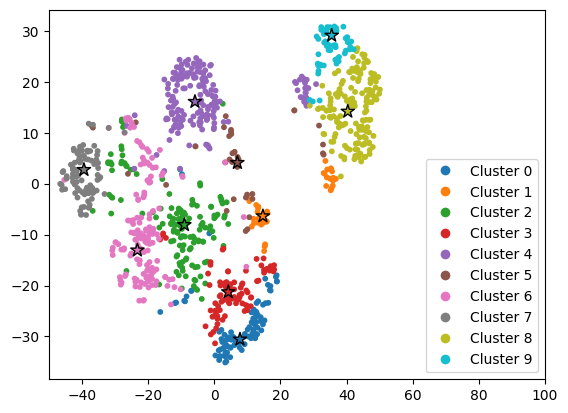

In [143]:
tsne = TSNE(n_components=2, n_jobs=-1)
tsne_dataset = np.concatenate((downsampled_dataset, xmeans_centroids))
tsne_labels = np.concatenate((downsampled_labels, range(n_clusters)))
tsne_map = tsne.fit_transform(tsne_dataset)

scatter = plt.scatter(tsne_map[:-n_clusters, 0], tsne_map[:-n_clusters, 1], c = tsne_labels[:-n_clusters], s=10, cmap='tab10')
plt.scatter(tsne_map[-n_clusters:, 0], tsne_map[-n_clusters:, 1], c = tsne_labels[-n_clusters:], s=100, cmap='tab10', marker='*', edgecolors='black')

# Get unique cluster labels
unique_labels = set(tsne_labels[:-n_clusters])

# Create a legend with a color for each cluster
legend_entries = []
for label in unique_labels:
    # Find the indices of data points with the current label
    indices = tsne_labels[:-n_clusters] == label
    # Add a legend entry for the current label with the corresponding color
    legend_entries.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8, label=f'Cluster {label}'))

# Add legend to the plot
plt.legend(handles=legend_entries, loc='lower right')
plt.xlim(-50,100)
plt.show()

## 5.3 Distribution of variables: within clusters vs whole dataset

Analysis of distribution of repubblican vs democrats in the clusters.

In [159]:
party_xt_pct = pd.crosstab(xmeans_labels, dataset_reduced['republicans_ratio'] > 0.5)
party_xt_pct

republicans_ratio,False,True
row_0,,
0,11336,8358
1,4565,1981
2,12837,16406
3,10789,7998
4,18791,17761
5,4233,4214
6,12696,16136
7,9601,8524
8,28783,3279


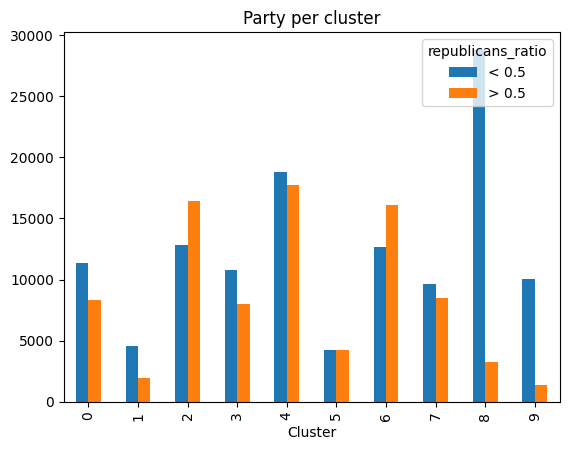

In [160]:
party_xt_pct.plot(kind='bar', stacked=False, 
                   title='Party per cluster')
plt.xlabel('Cluster')

# Set in the legend republicans_ratio >0.5 and <0.5
plt.legend(['< 0.5', '> 0.5'], loc='upper right', title = 'republicans_ratio')

plt.show()

In [161]:
populous_city_xt_pct = pd.crosstab(xmeans_labels, dataset_reduced['populous_city'])
populous_city_xt_pct

populous_city,0,1
row_0,,
0,19694,0
1,4211,2335
2,29243,0
3,18787,0
4,31973,4579
5,7332,1115
6,28832,0
7,18125,0
8,0,32062


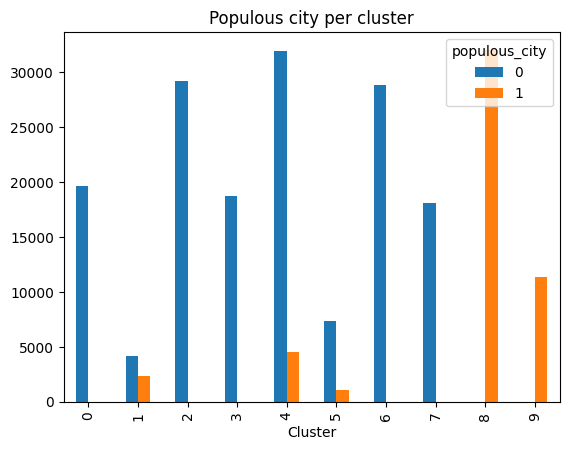

In [162]:
populous_city_xt_pct.plot(kind='bar', stacked=False, 
                   title='Populous city per cluster')
plt.xlabel('Cluster')
plt.show()

Let's explore some continuous variables, such as the arrested ratio, and look at clusters positively and negatively correlated to that variable. We can see that the distributions are very different amongst the two clusters, and they represent different trends which are present in the full distribution.

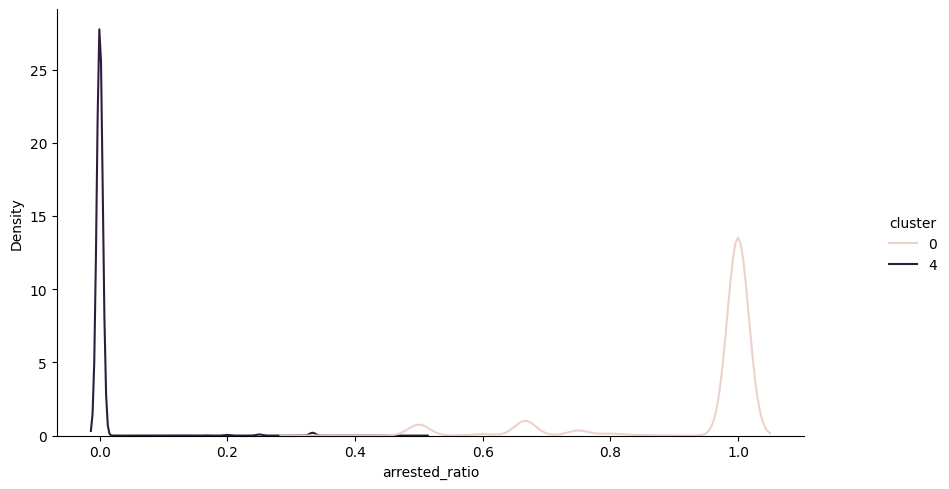

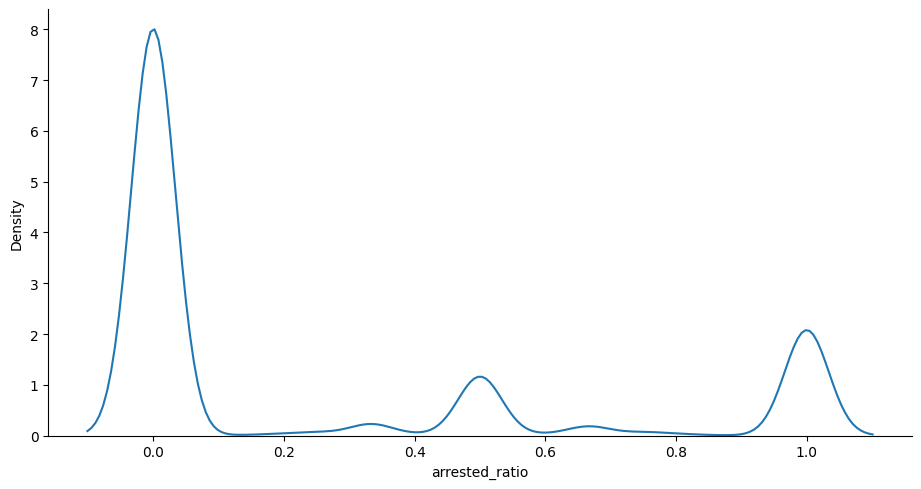

In [134]:
# Plot distribution of average age for whole dataset and clusters
arrested_analysis = [0, 4]
dataset_reduced_with_clusters = dataset_reduced.copy()
dataset_reduced_with_clusters['cluster'] = xmeans_labels
dataset_reduced_with_clusters_picked = dataset_reduced_with_clusters[(dataset_reduced_with_clusters['cluster'] == arrested_analysis[0]) | \
                                                              (dataset_reduced_with_clusters['cluster'] == arrested_analysis[1]) ]  

sns.displot(dataset_reduced_with_clusters_picked, x="arrested_ratio", kind='kde', hue="cluster")
plt.gcf().set_size_inches(10, 5)

sns.displot(dataset_reduced_with_clusters, x="arrested_ratio", kind='kde')
plt.gcf().set_size_inches(10, 5)
plt.show()